In [6]:
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
from datetime import timedelta
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Hourly, Stations
from sklearn.model_selection import KFold
import pvlib
import urllib.request
import time
from pvlib.location import Location

import pytorch_lightning as pl
import random
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import copy
pl.seed_everything(42)
random.seed(42)
torch.manual_seed(42)
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Seed set to 42


In [7]:
## ONLY RUN ONCE! ###
# download data from firebase
try:
    firebase_admin.delete_app(app)
except:
    print('making new app')
cred = credentials.Certificate("fb_key.json")
app = firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})




making new app


In [8]:
base_path = '/LH_Farm/pond_'
pond_number = 5
pond = f"{base_path}{pond_number}"  #Get data from the firebase
ref = db.reference(pond)
data = ref.get()

df = pd.DataFrame(data).T
#df = df[df['drone_id'].str.startswith('T', na=False)]
df

do     heading init_do init_pressure        lat  \
20230917_10:47:54  [18, 16]  174.729995      25       1004.25  37.703754   
20230917_10:49:32  [22, 21]  354.500000      25       1004.25  37.703758   
20230919_13:51:50      [26]   32.000000      27          0.00  37.703216   
20230919_13:56:13      [28]   82.720001      28         16.94  37.703231   
20230919_14:48:48  [26, 23]   82.500000      30       1003.38  37.703205   
...                     ...         ...     ...           ...        ...   
20250914_23:15:00     [134]         NaN     100        1001.2  37.704797   
20250914_23:25:00     [120]         NaN     100        1001.2   37.70481   
20250914_23:35:00     [119]         NaN     100        1000.6   37.70482   
20250914_23:45:00     [117]         NaN     100        1000.7  37.704827   
20250914_23:55:00     [131]         NaN     100        1000.5  37.704827   

                          lng pid            pressure          sid  \
20230917_10:47:54  -89.461372   5  [1035.94, 1035.94]            3   
20230917_10:49:32  -89.461425   5  [1032.63, 1004.00]            3   
20230919_13:51:50  -89.461967   5              [0.00]            3   
20230919_13:56:13  -89.461433   5             [16.94]            3   
20230919_14:48:48  -89.461906   5  [1029.13, 1028.69]            3   
...                       ...  ..                 ...          ...   
20250914_23:15:00  -89.461636   5            [1001.2]  7600-051400   
20250914_23:25:00  -89.461638   5            [1001.2]  7600-051400   
20250914_23:35:00  -89.461629   5            [1000.6]  7600-051400   
20250914_23:45:00   -89.46162   5            [1000.7]  7600-051400   
20250914_23:55:00   -89.46161   5            [1000.5]  7600-051400   

                             temp    type drone_id     TSI bloc_stat  \
20230917_10:47:54  [23.04, 23.04]   truck      NaN     NaN       NaN   
20230917_10:49:32  [23.04, 23.04]   truck      NaN     NaN       NaN   
20230919_13:51:50          [0.00]   truck      NaN     NaN       NaN   
20230919_13:56:13        [286.72]   truck      NaN     NaN       NaN   
20230919_14:48:48  [25.60, 25.60]   truck      NaN     NaN       NaN   
...                           ...     ...      ...     ...       ...   
20250914_23:15:00        [31.292]  a_buoy      NaN  [26.9]       [s]   
20250914_23:25:00        [28.737]  a_buoy      NaN  [26.3]       [s]   
20250914_23:35:00        [27.648]  a_buoy      NaN   [8.5]       [s]   
20250914_23:45:00        [27.623]  a_buoy      NaN   [3.1]       [s]   
20250914_23:55:00        [28.405]  a_buoy      NaN   [1.8]       [s]   

                     do_mgl sample_hz sensor_battv ysi_do_mgl  
20230917_10:47:54       NaN       NaN          NaN        NaN  
20230917_10:49:32       NaN       NaN          NaN        NaN  
20230919_13:51:50       NaN       NaN          NaN        NaN  
20230919_13:56:13       NaN       NaN          NaN        NaN  
20230919_14:48:48       NaN       NaN          NaN        NaN  
...                     ...       ...          ...        ...  
20250914_23:15:00   [9.792]       NaN          NaN        NaN  
20250914_23:25:00   [9.153]       NaN          NaN        NaN  
20250914_23:35:00   [9.235]       NaN          NaN        NaN  
20250914_23:45:00   [9.069]       NaN          NaN        NaN  
20250914_23:55:00  [10.013]       NaN          NaN        NaN  

[10729 rows x 18 columns]

In [9]:
# Remove outliers in DO and temperature lists
def outliers(lst):
    lst = np.array(lst)
    data = [x for x in lst if isinstance(x, (int, float, np.number, np.ndarray))]
    if len(data) == 0:
        return np.nan
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    return filtered_data

def remove_outliers_from_df(df):
    for column in df.columns:
        df[column] = df[column].apply(outliers)
    return df

# Calculate the weighted mean of DO and temp
def calculate_weighted_mean(lst):
    if not isinstance(lst, list):
        return lst
    num_double_weights = min(len(lst), 6)
    weights = [1] * (len(lst) - num_double_weights) + [2] * num_double_weights
    return np.average(lst, weights=weights)

def Convert_mean(df):
    for column in df.columns:
        df[column] = df[column].apply(calculate_weighted_mean)
    return df

In [10]:
def denormalize(predictions, mean, std):
    return predictions * std + mean

In [11]:
def norimalize(data, mean, std):
    return (data - mean) / std

In [12]:
# Introduce time as another feature
def fix_time(data):
    datetime_object= pd.to_datetime(data.index, format='%Y%m%d_%H:%M:%S')
  # print(datetime_object)
    datetime_object= datetime_object.round('60min').to_pydatetime()
  # print(data['datetime'])
  # data['year'] =  pd.DatetimeIndex(data['datetime']).year
  # data['month'] =pd.DatetimeIndex(data['datetime']).month
  # data['day'] =pd.DatetimeIndex(data['datetime']).day
  # data['hour'] = pd.DatetimeIndex(datetime_object).hour
  # data.set_index('datetime', inplace = True)
    return data

In [13]:
# Import external weather data
start = datetime(2024, 5, 30)
end = datetime(2024, 7, 20)
station = Stations()
station = station.nearby(37.708961, -89.449699)
station = station.fetch(1)
print(station)
weather_data = Hourly(station, start, end)
weather_data = weather_data.fetch()
print(weather_data)

                                     name country region   wmo  icao  \
id                                                                     
KMDH0  Carbondale / Murphysboro / De Soto      US     IL  <NA>  KMDH   

       latitude  longitude  elevation         timezone hourly_start  \
id                                                                    
KMDH0   37.7781    -89.252      125.0  America/Chicago   2006-01-01   

      hourly_end daily_start  daily_end monthly_start monthly_end  \
id                                                                  
KMDH0 2025-09-10  2006-01-01 2022-04-24    2006-01-01  2022-01-01   

           distance  
id                   
KMDH0  19007.484545  
                     temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt    pres  \
time                                                                          
2024-05-30 00:00:00  21.7  12.8  57.0   0.0   NaN   0.0   0.0   NaN  1020.6   
2024-05-30 01:00:00  18.3  12.3  68.0   0.0   NaN   0.0   

In [14]:
latitude, longitude = 37.708961, -89.449699
location = Location(latitude, longitude)
times = pd.date_range(start='2024-05-30', end='2024-07-20', freq='1H')
solar_position = location.get_solarposition(times)
clear_sky = location.get_clearsky(times)
#print(solar_position)
print(clear_sky)
external_data = pd.concat([weather_data, clear_sky], axis = 1)
print(external_data)

                            ghi         dni         dhi
2024-05-30 00:00:00  116.068740  302.169263   51.539928
2024-05-30 01:00:00    0.944018    2.547291    0.871253
2024-05-30 02:00:00    0.000000    0.000000    0.000000
2024-05-30 03:00:00    0.000000    0.000000    0.000000
2024-05-30 04:00:00    0.000000    0.000000    0.000000
...                         ...         ...         ...
2024-07-19 20:00:00  824.882460  793.883927  139.386951
2024-07-19 21:00:00  694.755848  755.652970  129.024569
2024-07-19 22:00:00  524.837348  688.080088  113.654963
2024-07-19 23:00:00  329.493643  566.549067   91.223507
2024-07-20 00:00:00  131.846623  333.248527   55.224638

[1225 rows x 3 columns]
                     temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt    pres  \
2024-05-30 00:00:00  21.7  12.8  57.0   0.0   NaN   0.0   0.0   NaN  1020.6   
2024-05-30 01:00:00  18.3  12.3  68.0   0.0   NaN   0.0   0.0   NaN  1020.9   
2024-05-30 02:00:00  15.6  11.8  78.0   0.0   NaN  40.0  11.2   Na

In [15]:
duration = 10
start = str(round(time.time()*1000) - duration * 24 * 50 * 60 * 1000)
end = str(round(time.time() * 1000))

with urllib.request.urlopen('https://api.sensestream.org/observations/measurements/hboi_aqua_2/0?start=' + start + '&end=' + end) as response:
    weather_data = json.load(response)


In [16]:
dftime = external_data
dftime['time'] = pd.to_datetime(dftime.index)  # Convert the 'time' column to datetime if not already
dftime.set_index('time', inplace=True)
start_time = '2024-07-17'
end_time = '2024-07-18'

# Select the data in the time range
time_range_data = dftime.loc[start_time:end_time]

In [17]:
def convert_to_mgl(do_input, t, p):
    T = t + 273.15; #temperature in kelvin
    P = p * 9.869233e-4; #pressure in atm

    DO_baseline = math.exp(-139.34411 + 1.575701e5/T - 6.642308e7/math.pow(T, 2) + 1.2438e10/math.pow(T, 3) - 8.621949e11/math.pow(T, 4))

    Fs = math.exp(0 * (0.017674 - 10.754/T + 2140.7/math.pow(T, 2)))

    theta = 0.000975 - 1.426e-5 * t + 6.436e-8 * math.pow(t, 2)
    u = math.exp(11.8571 - 3840.7/T - 216961/math.pow(T, 2))
    Fp = (P - u) * (1 - theta * P) / (1 - u) / (1 - theta)

    DO_corrected = DO_baseline * Fs * Fp
    DO_mgl = do_input / 100 * DO_corrected

    return DO_mgl

In [19]:
# Incorportae all functions above, get processed temp and do data wth pond_id
def getData_5feature_tensor(pond_number):
    base_path = '/LH_Farm/pond_'
    pond = f"{base_path}{pond_number}"  #Get data from the firebase
    ref = db.reference(pond)
    data = ref.get()
    df = pd.DataFrame(data)
    df = df.T
    
    df = df[df['type'] == 'a_buoy']
    df = df[df.index.str[:8] > '20250701']
    df_do_related = df[['do', 'temp', 'pressure']]
    df_init_do = df[['init_do']]

    #do_res = remove_outliers_from_df(df_do_related)
    do_mean = Convert_mean(df_do_related) # Get mean of DO
    do_mean = pd.concat([do_mean, df_init_do], axis=1)
    do_mean['do'] = do_mean.apply(lambda row: convert_to_mgl(100 * row['do'] / row['init_do'], row['temp'], row['pressure']), axis=1)

    do_mean['datetime'] = pd.to_datetime(do_mean.index, format='%Y%m%d_%H:%M:%S')

    do_mean['datetime'] = do_mean['datetime'].dt.tz_localize('UTC')
    do_mean['datetime'] = do_mean['datetime'].dt.tz_convert('America/Chicago')

    do_mean['hour'] = do_mean['datetime'].dt.hour
    do_mean['minute'] = do_mean['datetime'].dt.minute
    do_mean['hour_minute'] = do_mean['hour'] + do_mean['minute'] / 60.0

    do_mean['formatted_index'] = do_mean['datetime'].dt.strftime('%Y%m%d_%H:%M:%S')
    do_mean = do_mean.set_index('formatted_index', drop=True)
    do_mean = do_mean.drop('datetime', axis = 1)
    do_mean = do_mean.drop('hour', axis = 1)
    do_mean = do_mean.drop('minute', axis = 1)
    do_mean = do_mean.iloc[:-10]
    do_mean['datetime'] = pd.to_datetime(do_mean.index, format='%Y%m%d_%H:%M:%S')

    do_mean_index = do_mean.index


    do_mean = do_mean[['do', 'temp', 'hour_minute']]
    do_mean = do_mean.dropna()
    with open('latest_data.json', 'w') as f:
        json.dump(data, f)

    return do_mean


In [20]:
getData_5feature_tensor(5)

do    temp  hour_minute
formatted_index                                 
20250813_18:55:00  5.526135  32.224    18.916667
20250813_19:05:00  5.458423  32.180    19.083333
20250813_19:15:00  5.462650  32.128    19.250000
20250813_19:25:00  6.041240  32.093    19.416667
20250813_19:35:00  5.396173  32.075    19.583333
...                     ...     ...          ...
20250914_16:35:00  8.894412  31.753    16.583333
20250914_16:45:00  8.365040  31.910    16.750000
20250914_16:55:00  8.532364  31.744    16.916667
20250914_17:05:00  9.038521  31.744    17.083333
20250914_17:15:00  8.828967  31.701    17.250000

[4592 rows x 3 columns]

In [22]:
data_59 = getData_5feature_tensor(30)
data_59

do    temp  hour_minute
formatted_index                                  
20250701_19:06:00  17.431207  29.385    19.100000
20250701_19:16:00  17.295047  29.342    19.266667
20250701_19:26:00  17.018171  29.257    19.433333
20250701_19:36:00  17.113507  29.197    19.600000
20250701_19:46:00  17.282447  29.145    19.766667
...                      ...     ...          ...
20250914_16:34:00  10.856871  28.529    16.566667
20250914_16:44:00  10.928917  28.546    16.733333
20250914_16:54:00  10.773236  28.555    16.900000
20250914_17:04:00  10.540862  28.572    17.066667
20250914_17:14:00  10.532500  28.623    17.233333

[10783 rows x 3 columns]

In [23]:
"""data_59['key'] = 1
external_data['key'] = 1
data_joined = pd.merge(data_59, external_data, on='key').drop("key", axis=1)
data_joined['time_diff'] = np.abs(data_joined['datetime_x'] - data_joined['datetime_y'])
cloest_match = data_joined.loc[data_joined.groupby('datetime_x')['time_diff'].idxmin()]
cloest_match = cloest_match.drop('time_diff', axis= 1).reset_index(drop = True)
cloest_match"""

'data_59[\'key\'] = 1\nexternal_data[\'key\'] = 1\ndata_joined = pd.merge(data_59, external_data, on=\'key\').drop("key", axis=1)\ndata_joined[\'time_diff\'] = np.abs(data_joined[\'datetime_x\'] - data_joined[\'datetime_y\'])\ncloest_match = data_joined.loc[data_joined.groupby(\'datetime_x\')[\'time_diff\'].idxmin()]\ncloest_match = cloest_match.drop(\'time_diff\', axis= 1).reset_index(drop = True)\ncloest_match'

In [24]:
# Plot up to date DO, temperature trend
def OriginalDoPlot(pond_id, ax):
    data = getData(pond_id)

    ax.plot(data['do'], marker='o', label = 'DO')
    #ax.plot(data['temp'], marker='o', label = 'Temp')
    ax.set_title('Time-Series Prediction for pond %d'%pond_id)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Change interval as needed
    ax.xaxis.set_tick_params(rotation=45)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.tight_layout()


In [25]:
# Get data from all six ponds
def getAllData():
    res = []
    data_1 = getData(1)
    data_2 = getData(2)
    data_5 = getData(5)
    data_18 = getData(18)
    data_19 = getData(19)
    data_21 = getData(21)
    data_22 = getData(22)
    data_30 = getData(30)
    data_52 = getData(52)
    res.append(data_59)
    res.append(data_60)
    #res.append(data_61)
    res.append(data_65)
    res.append(data_66)
    #res.append(data_67)

    return res
#data_62 = getData(62)
#data_68 = getData(68)


In [26]:
# Get data from all six ponds
def getAllData_5_feature():
    res = []
    data_1 = getData_5feature_tensor(1)
    data_2 = getData_5feature_tensor(2)
    data_5 = getData_5feature_tensor(5)
    data_18 = getData_5feature_tensor(18)
    data_19 = getData_5feature_tensor(19)
    data_21 = getData_5feature_tensor(21)
    data_22 = getData_5feature_tensor(22)
    data_30 = getData_5feature_tensor(30)
    data_52 = getData_5feature_tensor(52)
    res.append(data_1)
    res.append(data_2)
    res.append(data_5)
    #res.append(data_18)
    res.append(data_19)
    res.append(data_21)
    res.append(data_22)
    #res.append(data_30)
    res.append(data_52)

    return res

#18 validation, 30 test

In [ ]:
def getVal():
    res = []
    data_18 = getData_5feature_tensor(18)
    res.append(data_18)

    return res

In [28]:
def getTest_set():
    res = []
    data_30 = getData_5feature_tensor(30)

    res.append(data_30)
    return res


In [29]:
def plot_all_Original():
    fig, axes = plt.subplots(3, 2, figsize=(20,15))
    axes = axes.flatten()
  # print(axes)

    for i, axe in enumerate(axes):
        id = [59,60,61,65,66,67]
        OriginalDoPlot(id[i], axe)

In [30]:
#plot_all_Original()

In [31]:
# Sliding windows used to split data to x and y
def sliding_windows(data, seq_length, n_future):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+seq_length+n_future]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [32]:
def Load_Data(data):
    seq_length = 4    # Choose params for sliding window, use 4 to predict 2 futures here
    n_future = 1
    x_de, y_de = sliding_windows(data, seq_length, n_future)

    train_size = int(len(y_de) * 0.7) # Split the datasets to train/val/test
    val_size = int(len(y_de) * 0.2)
    test_size = len(y_de) - train_size - val_size

    x_train = x_de[:train_size]
    y_train = y_de[:train_size]

    train_data = np.concatenate((x_train, y_train), axis=1)
    train_data_rs = np.reshape(train_data, (train_data.shape[0]*train_data.shape[1], train_data.shape[2]))
    scaler = StandardScaler()
    scaler.fit(train_data_rs)
    mean = scaler.mean_
    std = np.sqrt(scaler.var_)
    data_no = scaler.transform(data)

    x, y = sliding_windows(data_no, seq_length, n_future)
    dataX = Variable(torch.Tensor(np.array(x))) # Convert to tensor
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
    #trainY_time = trainY[:,:,2]
    trainY = trainY[:,:,0:2]
    
    valX = Variable(torch.Tensor(np.array(x[train_size:train_size+val_size])))
    valY = Variable(torch.Tensor(np.array(y[train_size:train_size+val_size])))
    #valY_time = valY[:,:,2]
    valY = valY[:,:,0:2]
    
    testX = Variable(torch.Tensor(np.array(x[train_size+val_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size+val_size:len(y)])))
    #testY_time = testY[:,:,2]
    testY = testY[:,:,0:2]




    return trainX, trainY, valX, valY, testX, testY, dataX, dataY, train_size, val_size, mean, std

In [33]:
def train_test_split(res):
    
    train_X = []
    train_Y = []
    val_X = []
    val_Y = []
    test_X = []
    test_Y = []
    data_X = []
    data_Y = []
      # Integrate all ponds data together to build one model
    for i in res:
        train_x, train_y, val_x, val_y, test_x, test_y, data_x, data_y,_,_, mean, std = Load_Data(i)
        train_X.extend(train_x)
        train_Y.extend(train_y)
        val_X.extend(val_x)
        val_Y.extend(val_y)
        test_X.extend(test_x)
        test_Y.extend(test_y)
        data_X.extend(data_x)
        data_Y.extend(data_y)
    train_X = torch.stack(train_X).to(device)
    train_Y = torch.stack(train_Y).to(device)
    val_X = torch.stack(val_X).to(device)
    val_Y = torch.stack(val_Y).to(device)
    test_X = torch.stack(test_X).to(device)
    test_Y = torch.stack(test_Y).to(device)
    data_X = torch.stack(data_X).to(device)
    data_Y = torch.stack(data_Y).to(device)

    return train_X, train_Y, val_X, val_Y, test_X, test_Y, data_X, data_Y, mean, std

In [34]:
res = getAllData_5_feature()


In [62]:
res = getAllData_5_feature()
train_X, train_Y, val_X, val_Y, test_X, test_Y, data_X, data_Y, mean, std = train_test_split(res)


In [41]:
class LSTM(nn.Module):
    def __init__(self, num_classes=2, input_size=3, hidden_size=512, num_layers=3):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # LSTM with dropout (注意：只在num_layers > 1时才能使用LSTM内部的dropout)
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True, 
            dropout=0.3 if num_layers > 1 else 0  # LSTM层间dropout
        )
        
        # Dropout层
        self.dropout1 = nn.Dropout(0.5)  # 第一个FC层前的dropout
        self.dropout2 = nn.Dropout(0.4)  # 第二个FC层前的dropout
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(128)
        
        # 全连接层
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.fc_2 = nn.Linear(128, num_classes)
        
        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        """Xavier初始化帮助防止梯度消失/爆炸"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)

    def forward(self, x):
        # 初始化隐藏状态
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM前向传播
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        
        # 取最后一个时间步的输出
        out = output[:, -1, :]
        
        # 应用Batch Norm和Dropout
        out = self.bn1(out)
        out = self.dropout1(out)
        
        # 第一个全连接层
        out = self.fc_1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        
        # 输出层
        out = self.fc_2(out)
        
        # Reshape到期望的输出格式
        out = out.view(out.size(0), 1, -1)
        
        return out

In [42]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_model = model.state_dict().copy()
        self.val_loss_min = val_loss


In [43]:
def custom_loss(y_pred, y_true):
    mse_loss = F.mse_loss(y_pred, y_true)  # Mean Squared Error (MSE)
    penalty = torch.mean(torch.relu(y_pred - y_true) ** 2)  # Penalty for y_pred > y_true
    #time_penalty_condition = (hour_minute >= 5.5) & (hour_minute <= 6.5)
    #time_penalty = torch.mean(time_penalty_condition.float() * (y_pred[0] - y_true[0]) ** 2)
    return mse_loss + penalty

In [44]:
"""def custom_loss(y_pred, y_true, sigma=1.0):
    # Calculate the squared differences
    diff = y_true - y_pred
    # Apply Gaussian kernel
    gaussian_kernel = torch.exp(-(diff ** 2) / (2 * sigma ** 2))
    # Correntropy loss: 1 - Gaussian kernel
    correntropy_loss = 1 - gaussian_kernel.mean()
    return correntropy_loss"""

'def custom_loss(y_pred, y_true, sigma=1.0):\n    # Calculate the squared differences\n    diff = y_true - y_pred\n    # Apply Gaussian kernel\n    gaussian_kernel = torch.exp(-(diff ** 2) / (2 * sigma ** 2))\n    # Correntropy loss: 1 - Gaussian kernel\n    correntropy_loss = 1 - gaussian_kernel.mean()\n    return correntropy_loss'

In [45]:
def calculate_mae(y_pred, y_true):
    #Calculates the Mean Absolute Error (MAE)
    return torch.mean(torch.abs(y_pred - y_true))

def calculate_rmse(y_pred, y_true):
    #Calculates the Root Mean Squared Error (RMSE)
    return torch.sqrt(F.mse_loss(y_pred, y_true))
def calculate_r2(y_pred, y_true):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    
    return r2

def calculate_mape(predicted, actual):
    absolute_percentage_errors = np.abs((actual - predicted) / actual)
    mape = np.mean(absolute_percentage_errors) * 100  # Convert to percentage
    
    return mape

In [48]:

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
criterion = nn.MSELoss()
res = getAllData_5_feature()
val = getVal()
_, _, _, _, _, _, data_X, data_Y, mean, std = train_test_split(res)
_, _, _, _, _, _, val_X, val_Y, mean, std = train_test_split(val)
data_Y = data_Y[:,:,:1]
val_Y = val_Y[:,:,:1]
input_size = 3 # number of features
hidden_size = 64 # number of features in hidden state
num_layers = 3 # number of stacked lstm layers
num_classes = 2
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
n_epochs = 1000
learning_rate = 0.001 # 0.001 lr
# loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay = 1e-5)
early_stopping = EarlyStopping(patience=200, verbose=False)


for epoch in range(n_epochs):
    lstm.train()
    outputs = lstm(data_X) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0
    cus_loss = custom_loss(outputs, data_Y)
    loss = cus_loss
    train_losses.append(loss)
    train_mae = calculate_mae(outputs, data_Y)
    train_rmse = calculate_rmse(outputs, data_Y)
    loss.backward() # calculates the loss of the loss function
    optimizer.step() # improve from loss, i.e backprop
    # test loss

    lstm.eval()
    val_preds = lstm(val_X)
    val_loss = custom_loss(val_preds, val_Y)
    #cus_loss_val  = custom_loss(val_preds, val_Y)
    #phy_loss_val = physics_loss(delta_attr_val, y_ago_val, val_preds, val_Y, upper_val, lower_val, alpha, beta, gamma)
    #val_loss = cus_loss_val + phy_loss_val
    val_losses.append(val_loss)
    val_mae = calculate_mae(val_preds, val_Y)
    val_rmse = calculate_rmse(val_preds, val_Y)


    #if epoch % 100 == 0:
    #    print("Epoch: %d, train loss: %1.5f" % (epoch, loss.item()))

    if epoch % 100 == 0:
        print("-" * 40)
        print("Epoch: {}".format(epoch))
        print("-" * 40)
        print("{:<15} {:<15} {:<15} ".format('Metric', 'Train', 'Validation', 'Test'))
        print("-" * 40)
        print("{:<15} {:<15.5f} {:<15.5f} ".format('Loss', loss.item(), val_loss.item()))
        print("{:<15} {:<15.5f} {:<15.5f} ".format('MAE', train_mae.item(), val_mae.item()))
        print("{:<15} {:<15.5f} {:<15.5f} ".format('RMSE', train_rmse.item(), val_rmse.item()))
    if epoch % 100 == 0:
        print("Epoch: %d, train loss: %1.5f, val loss: %1.5f" % (epoch, loss.item(), val_loss.item()))
    early_stopping(val_loss.item(), lstm)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    if early_stopping.early_stop:
        print("Early stopping")
        break



----------------------------------------
Epoch: 0
----------------------------------------
Metric          Train           Validation      
----------------------------------------
Loss            3.48341         1.41237         
MAE             1.19160         0.81501         
RMSE            1.58604         1.00007         
Epoch: 0, train loss: 3.48341, val loss: 1.41237
----------------------------------------
Epoch: 100
----------------------------------------
Metric          Train           Validation      
----------------------------------------
Loss            0.42149         0.06793         
MAE             0.36534         0.17674         
RMSE            0.58883         0.25039         
Epoch: 100, train loss: 0.42149, val loss: 0.06793
----------------------------------------
Epoch: 200
----------------------------------------
Metric          Train           Validation      
----------------------------------------
Loss            0.23677         0.04303         
MAE       

In [56]:
filepath = 'models/lstm_on_bouy.pth'
torch.save(lstm.state_dict(), filepath)

In [63]:

test_set= getTest_set()
train_x, train_y, val_x, val_y, test_x, test_y, data_X, data_Y, t_mean, t_std = train_test_split(test_set)
train_y = train_y[:,:,:1]
test_y = test_y[:,:,:1]
data_Y = data_Y[:,:,:1]

std = std[0]
mean = mean[0]


In [64]:
def test_stats():

    test_set= getTest_set()
    train_x, train_y, val_x, val_y, test_x, test_y, data_X, data_Y, mean, std = train_test_split(test_set)
    train_y = train_y[:,:,:1]
    test_y = test_y[:,:,:1]
    data_Y = data_Y[:,:,:1]
    std = std[0]
    mean = mean[0]
    with torch.no_grad():
        lstm.eval()
        #delta_attr, y_ago, upper, lower = prepare_physics_components(data_X, data_Y)
        test_preds = lstm(data_X)[:,:,:1]
  
        y_test_d = denormalize(data_Y, mean, std)
        test_preds_d = denormalize(test_preds, mean, std)

        test_preds_np = test_preds_d.cpu().numpy()  # Convert test predictions to NumPy
        y_test_np = y_test_d.cpu().numpy()  # Convert ground truth to NumPy
        cus_loss = custom_loss(test_preds_d, y_test_d)
        #phy_loss = physics_loss(delta_attr, y_ago, test_preds_d, y_test_d, upper, lower, alpha, beta,gamma)
        test_loss = custom_loss(test_preds_d, y_test_d)

        test_mae = calculate_mae(test_preds_d, y_test_d)
        test_rmse = calculate_rmse(test_preds_d, y_test_d)
        test_accuracy = 1 - np.mean(np.abs(np.true_divide(y_test_np - test_preds_np, y_test_np)))
        test_mape = calculate_mape(test_preds_np, y_test_np)
    print("-" * 20)
    print("Test Set Metrics:")
    print("-" * 20)
    print("Test Loss: {:.5f}".format(test_loss.item()))
    print("Test MAE: {:.5f}".format(test_mae.item()))
    print("Test RMSE: {:.5f}".format(test_rmse.item()))
    print("Test MAPE: {:.5f}".format(test_mape.item()))
    print("Accuracy: ", test_accuracy)
test_stats()

--------------------
Test Set Metrics:
--------------------
Test Loss: 0.21856
Test MAE: 0.27253
Test RMSE: 0.44026
Test MAPE: 3.28336
Accuracy:  0.9671664498746395


In [55]:
def loss_plot():
    train_X, train_Y, val_X, val_Y, test_X, test_Y = train_test_split()
    plt.figure(figsize=(12, 5))
      # Plotting the loss
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), [loss.detach().numpy() for loss in train_losses], label='Train Loss')
    plt.plot(range(len(val_losses)), [loss.detach().numpy() for loss in val_losses], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss over Epochs')
    plt.title('(a)',loc='left',x=-0.08, y=1,fontsize=13)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [57]:
def convert_tensor(arr):
    last_sequence = Variable(torch.Tensor(np.array(arr)))
    last_sequence = last_sequence.unsqueeze(0)
    last_sequence = last_sequence.reshape(last_sequence.shape[1], last_sequence.shape[2])
    #last_sequence = scaler.transform(last_sequence)
    last_sequence = Variable(torch.Tensor(np.array(last_sequence)))
    last_sequence = last_sequence.unsqueeze(0)
    last_sequence = last_sequence.to(device)
    return last_sequence

In [58]:
print(outputs.shape)

torch.Size([40243, 1, 2])


In [72]:
def Predict(pond_id, n_ahead):
    """
    修改后的预测函数，适用于每10分钟采样的24小时连续数据
    
    Args:
        pond_id: 池塘ID
        n_ahead: 预测未来多少个时间步（每步10分钟）
    
    Returns:
        dataX, do, future_predicts, train_size, val_size, mean, std
    """
    # 获取数据
    data = getData_5feature_tensor(pond_id)
    future_predicts = []
    _, _, _, _, _, _, dataX, dataY, train_size, val_size, mean, std = Load_Data(data)
    do = data.iloc[:, :]

    # 使用最后4个观测值作为初始序列
    lastDay = do.tail(4) 
    last_hour_minute = lastDay['hour_minute'].iloc[-1]
    hold = lastDay
    lastDay = norimalize(lastDay, mean, std)
    
    # 获取最后的日期时间
    last_date = data.index[-1]
    last_date = pd.to_datetime(data.index[-1], format='%Y%m%d_%H:%M:%S')
    
    predicted_datetimes = []
    cur_hour_minute = last_hour_minute

    # 递归预测n_ahead步
    for i in range(n_ahead):
        # 计算下一个时间点（每10分钟增加）
        next_time_minutes = (cur_hour_minute * 60 + 10) % (24 * 60)  # 转换为分钟，加10分钟，24小时循环
        next_hour_minute = next_time_minutes / 60.0  # 转换回小时格式
        
        # 更新日期时间（每10分钟）
        last_date = last_date + timedelta(minutes=10)
        predicted_datetimes.append(last_date)
        
        cur_hour_minute = next_hour_minute

        # 转换为张量进行预测
        last_sequence = convert_tensor(lastDay)
        
        # 模型预测
        lstm.eval()
        with torch.no_grad():
            future_predict = lstm(last_sequence)
        
        # 处理预测输出
        future_predict = future_predict[0, :, :]  # 假设输出形状为 (1, seq_len, features)
        future_predict = future_predict.detach().cpu().numpy()
        
        # 由于模型只输出2个特征（do, temp），但标准化时可能有3个特征
        # 需要为第三个特征（hour_minute）添加值
        if future_predict.shape[1] == 2:  # 如果模型只输出2个特征
            # 添加hour_minute特征
            hour_minute_column = np.full((future_predict.shape[0], 1), next_hour_minute)
            future_predict = np.concatenate((future_predict, hour_minute_column), axis=1)
        
        # 反标准化
        future_predict_de = denormalize(future_predict, mean, std)
        
        # 确保hour_minute特征正确
        future_predict_de[:, 2] = next_hour_minute  # 第三列是hour_minute
        
        future_predicts.append(future_predict_de)

        # 重新标准化用于下一次预测
        future_predict_de_norm = norimalize(future_predict_de, mean, std)
        
        # 更新序列：移除最旧的观测，添加新预测
        lastDay = np.append(lastDay, future_predict_de_norm, axis=0)
        lastDay = lastDay[1:, :]  # 移除第一行，保持序列长度为4

    future_predicts = np.array(future_predicts)
    
    return dataX, do, future_predicts, train_size, val_size, mean, std

In [73]:
dataX, do, future_predicts, train_size, val_size, mean, std = Predict(1,6)
future_predicts

array([[[19.21470497, 33.51830813, 17.81666667]],

       [[18.30781653, 33.17638646, 17.98333333]],

       [[17.64393443, 32.94280857, 18.15      ]],

       [[17.12660202, 32.76395124, 18.31666667]],

       [[16.69606561, 32.61130622, 18.48333333]],

       [[16.35326691, 32.48711104, 18.65      ]]])

In [81]:
def Plotting_do(do,data_predict,future_predict,train_size,val_size,pond_id,ax):
    ax.plot(do, color = 'blue', label = 'Original Data')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    future_indices = np.arange(len(do+1), len(do+1) + len(future_predict))

    #ax.axvline(x=train_size, c='y', linestyle='--', label = 'Train-Val-split')
    #ax.axvline(x=train_size+val_size, c='y', linestyle='--', label = 'Val-Test-split')
    ax.axvline(x=len(do), color='r', linestyle='--', label='Prediction Boundary')
    ax.plot(data_predict[:,:,0], color = 'orange', marker='.', label = 'Predicted Data')
    ax.plot(future_indices, future_predict[:,0,0], color='green', marker='.',label='Future Predicted Data')
    ax.legend()
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title('DO Prediction for pond %d'%pond_id)
    plt.tight_layout()



In [82]:
def Plotting_temp(do,data_predict,future_predict,train_size,val_size,pond_id,ax):
    ax.plot(do, color = 'blue', label = 'Original Temp')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    future_indices = np.arange(len(do+1), len(do+1) + len(future_predict))

    #ax.axvline(x=train_size, c='y', linestyle='--', label = 'Train-Val-split')
    #ax.axvline(x=train_size+val_size, c='y', linestyle='--', label = 'Val-Test-split')
    ax.axvline(x=len(do), color='r', linestyle='--', label='Prediction Boundary')
    ax.plot(data_predict[:,:,1], color = 'orange', marker='.', label = 'Predicted Temp')
    ax.plot(future_indices, future_predict[:,0,1], color='lime', marker='.',label='Future Predicted Temp')
    ax.legend()
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title('Temp Prediction for pond %d'%pond_id)
    plt.tight_layout()


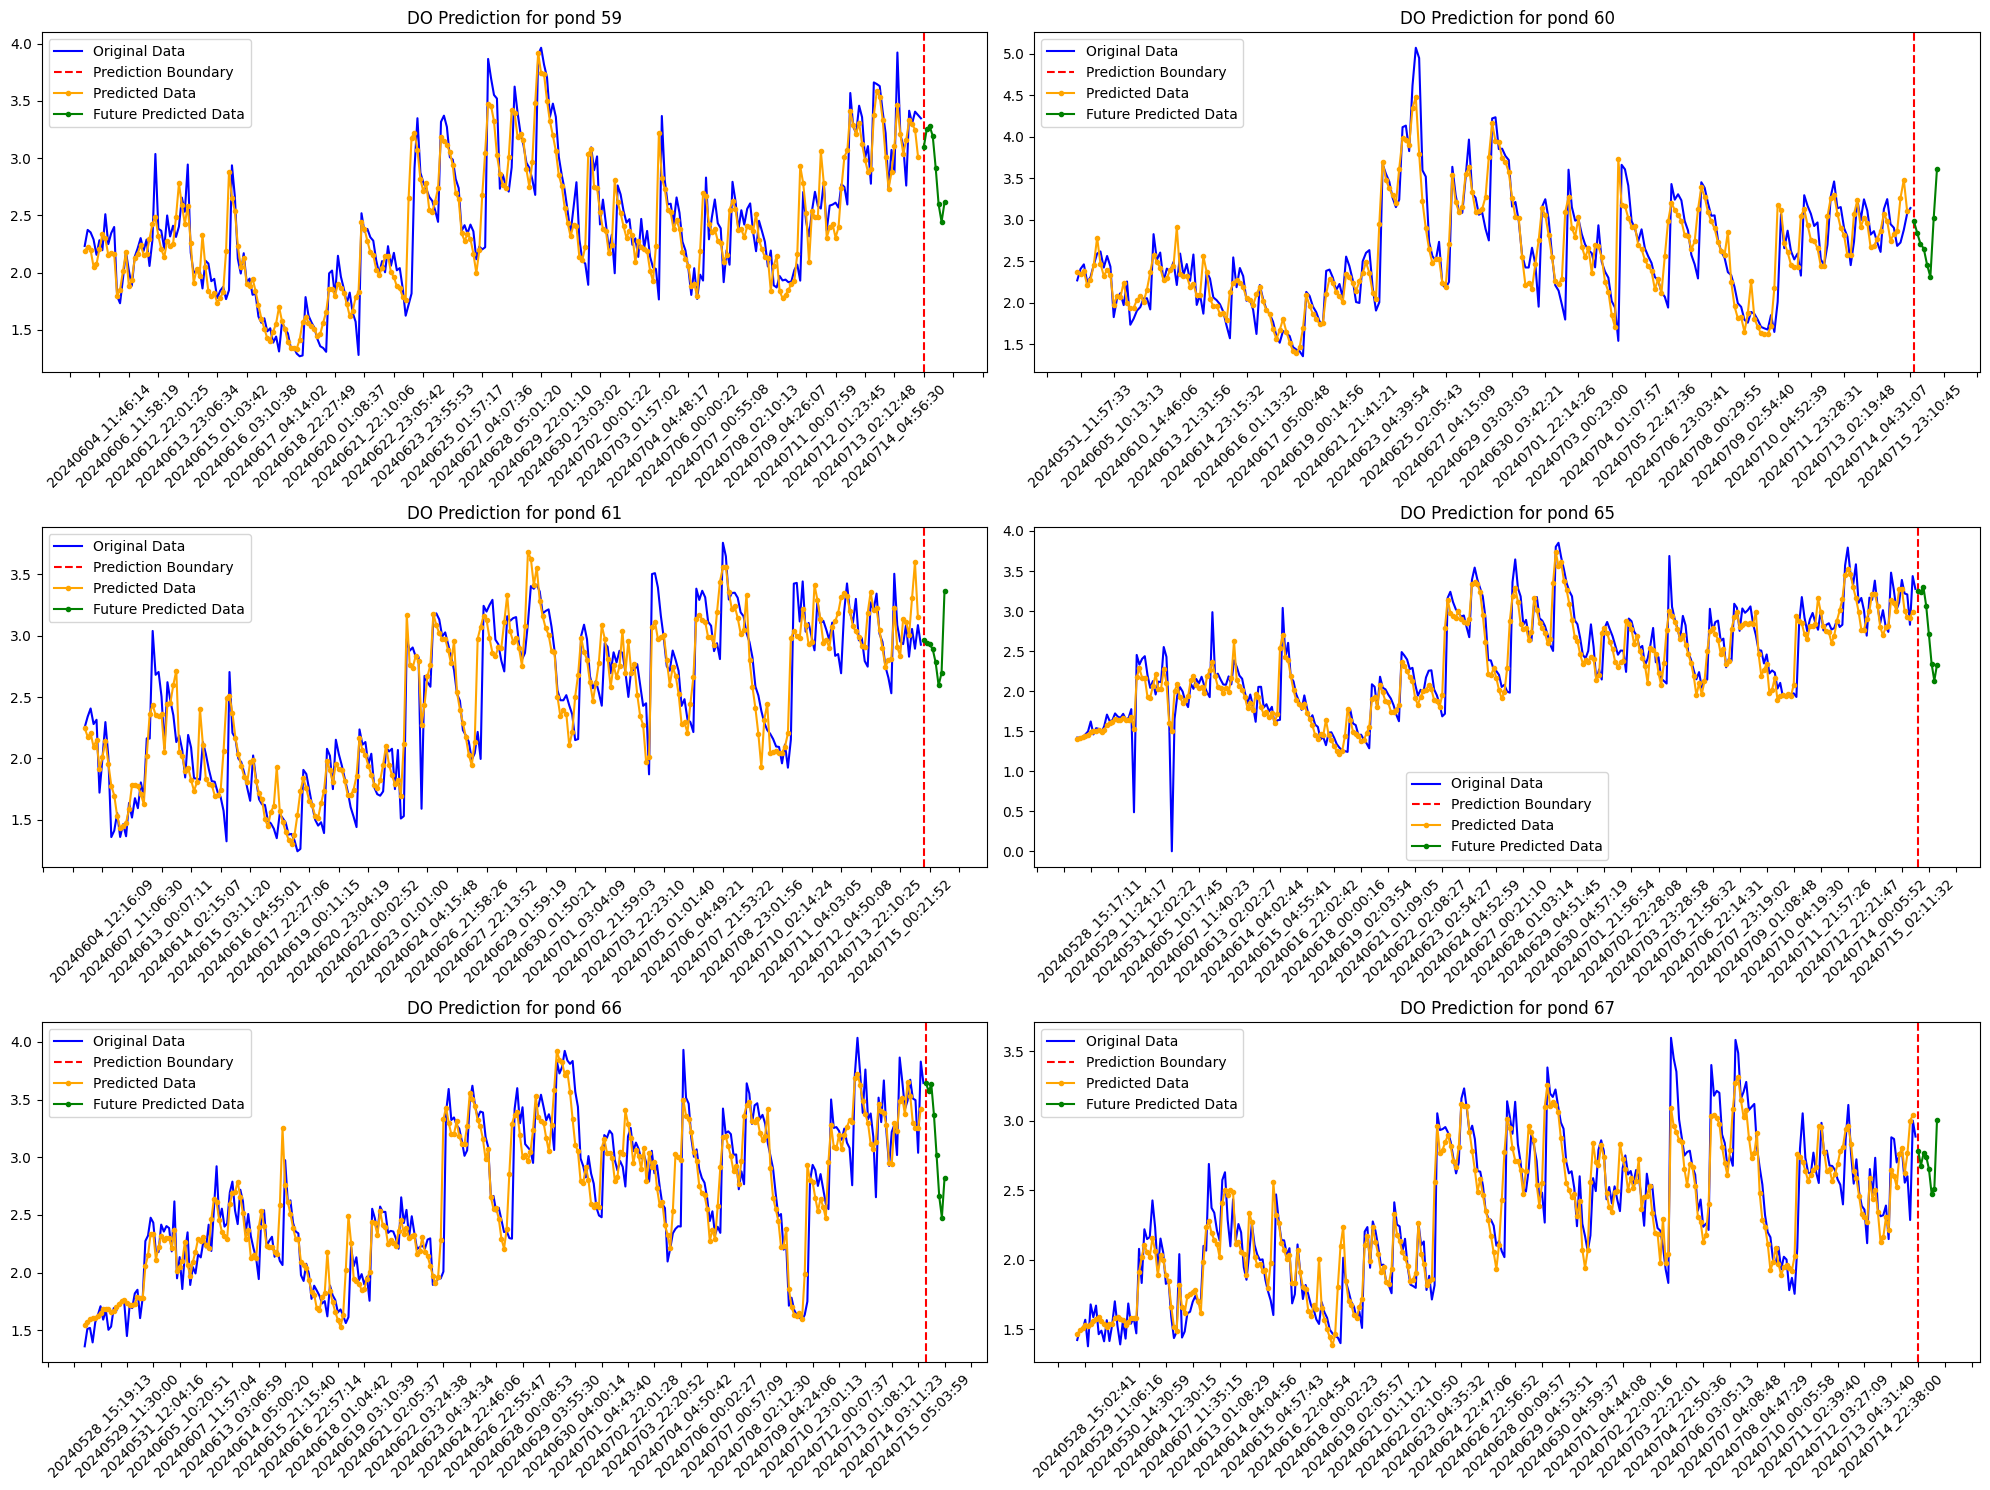

In [83]:
# Run this to Get all 6 plots with predicton
fig, axes = plt.subplots(3, 2, figsize=(20,15))
axes = axes.flatten()
# print(axes)

for i, axe in enumerate(axes):
    id = [59,60,61,65,66,67]
    dataX, do, future_predict, train_size,val_size, mean,std = Predict(id[i])
    # Get prediction result on train/val/test sets and plots
    do = do.iloc[3:, 0]

    train_predict = lstm(dataX)

  # last_train= train_predict[-1,0:]
  # train_predict = train_predict[:,:,0].reshape(-1,1)
  # last_train = last_train.reshape(-1, 1)

  # train_predict = torch.cat((train_predict, last_train), dim=0)
  # train_predict = train_predict[:,:,0]
  # print(train_predict.shape)
    data_predict = train_predict.data.numpy()

    placeholder_column = np.full((data_predict.shape[0], data_predict.shape[1], 5), 0.5)

    data_predict = np.concatenate((data_predict, placeholder_column), axis=2)

  #print(data_predict)

    data_predict = denormalize(data_predict, mean, std)
  #data_predict = pd.DataFrame(data_predict[:, 0, 0], index = do.index)
    Plotting_do(do,data_predict,future_predict,train_size,val_size,id[i],axe)



In [84]:
"""# Run this to Get all 6 plots with predicton
fig, axes = plt.subplots(3, 2, figsize=(20,15))
axes = axes.flatten()
# print(axes)

for i, axe in enumerate(axes):
    id = [59,60,61,65,66,67]
    dataX, do, future_predict, train_size,val_size, mean,std = Predict(id[i])
  # Get prediction result on train/val/test sets and plots
    do = do.iloc[3:, 1]

    train_predict = lstm(dataX)

  # last_train= train_predict[-1,0:]
  # train_predict = train_predict[:,:,0].reshape(-1,1)
  # last_train = last_train.reshape(-1, 1)

  # train_predict = torch.cat((train_predict, last_train), dim=0)
  # train_predict = train_predict[:,:,0]
  # print(train_predict.shape)
    data_predict = train_predict.data.numpy()

    placeholder_column = np.full((data_predict.shape[0], data_predict.shape[1], 4), 0.5)
    data_predict = np.concatenate((data_predict, placeholder_column), axis=2)
    data_predict = denormalize(data_predict, mean, std)

    Plotting_temp(do,data_predict,future_predict,train_size,val_size,id[i],axe)"""

'# Run this to Get all 6 plots with predicton\nfig, axes = plt.subplots(3, 2, figsize=(20,15))\naxes = axes.flatten()\n# print(axes)\n\nfor i, axe in enumerate(axes):\n    id = [59,60,61,65,66,67]\n    dataX, do, future_predict, train_size,val_size, mean,std = Predict(id[i])\n  # Get prediction result on train/val/test sets and plots\n    do = do.iloc[3:, 1]\n\n    train_predict = lstm(dataX)\n\n  # last_train= train_predict[-1,0:]\n  # train_predict = train_predict[:,:,0].reshape(-1,1)\n  # last_train = last_train.reshape(-1, 1)\n\n  # train_predict = torch.cat((train_predict, last_train), dim=0)\n  # train_predict = train_predict[:,:,0]\n  # print(train_predict.shape)\n    data_predict = train_predict.data.numpy()\n\n    placeholder_column = np.full((data_predict.shape[0], data_predict.shape[1], 4), 0.5)\n    data_predict = np.concatenate((data_predict, placeholder_column), axis=2)\n    data_predict = denormalize(data_predict, mean, std)\n\n    Plotting_temp(do,data_predict,future_pr

In [85]:
def Compare_predict_result(pond_id):
    _, _, arr, _, _, _,_ = Predict(pond_id)
    suohou = arr[:, :, :]
    suohou_shijian = suohou[:,-1]
    suohou_shijian
    
    gelie = getData(pond_id)
    gelie['datetime'] = pd.to_datetime(gelie.index, format='%Y%m%d_%H:%M:%S')

    if pond_id == 65:
         gelie = gelie[(gelie['datetime'].dt.month >= 5) & (gelie['datetime'].dt.month <= 7)]
    gelie = gelie.tail(10)


    gelie['hour'] = gelie['datetime'].dt.hour
    suohou_2d = suohou.reshape(suohou.shape[0], suohou.shape[2])
    gelie_index = gelie.index
    # Create DataFrame
    suohou_df = pd.DataFrame(suohou_2d, columns=['do', 'temp', 'ghi', 'dni', 'wspd', 'hour_array'])
    combined_df = pd.merge(suohou_df, 
                        gelie, 
                        left_on='hour_array', 
                        right_on='hour', 
                        how='inner')

    result = combined_df[['do_x','do_y','datetime']]
    result = result.rename(columns={'do_x': 'do_predicted'})
    result = result.rename(columns={'do_y': 'do_observed'})
    
    #result = result.set_index(gelie.index)
    #result_index = result['datetime']
    #result = result.set_index(result_index)
    #result = result.drop('datetime', axis = 1)

    differences = result['do_predicted'] - result['do_observed']
    accuracy  = 1 - np.abs(np.true_divide(differences, result['do_observed']))
    result = result[[ 'datetime', 'do_predicted', 'do_observed']]
    result['accuracy %'] = round(accuracy * 100,3)
    return result


In [86]:
#result = Compare_predict_result(65)

In [87]:
def accuracy_depreciate_plot(pond_ids):
    n_rows = (len(pond_ids) + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows), sharex=True, sharey = True)
    axes = axes.flatten()

    # Iterate through each pond ID and its corresponding axis
    for i, pond_id in enumerate(pond_ids):
        # Get the result DataFrame from Compare_predict_result function
        result = Compare_predict_result(pond_id)

        # Plot accuracy with respect to the index
        axes[i].plot(result.index, result['accuracy %'], marker='o', linestyle='-')
        axes[i].set_title(f'Accuracy with Respect to Index for Pond {pond_id}')
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Accuracy (%)')


    plt.tight_layout()
    plt.show()
pond_ids = [59, 60, 61, 65, 66, 67]
#accuracy_depreciate_plot(pond_ids)


In [88]:
def Predict_difference(pond_id):
    data = getData_5feature_tensor(pond_id)
    if pond_id == 65:
        data.index = pd.to_datetime(data.index, format='%Y%m%d_%H:%M:%S')
        data = data[(data.index.month >= 5) & (data.index.month <= 7)]
    
    future_predicts = []
    _, _, _, _, _, _, dataX ,dataY,train_size,val_size, mean,std = Load_Data(data)
    do = data.iloc[2:,:]
    train_predict = lstm(dataX)[:,:,:1]
    train_predict = train_predict.data.numpy()
    train_predict = denormalize(train_predict, mean, std)
    real_values = do.iloc[3:, 0].values
    predicted_values = train_predict[:, 0, 0]
    predicted_values = predicted_values[:-1]
    differences = predicted_values - real_values
    do_predict = do.iloc[3:,:]
    accuracy = 1 - np.abs(np.true_divide(differences, real_values))
    accuracy[accuracy < 0] = 0
    df_diff = pd.DataFrame({
        'pond_id': pond_id,
        'timestamp': do_predict.index,
        'real_value': real_values,
        'predicted_value': predicted_values,
        'difference': differences,
        'accuracy': accuracy
    })
    
    return df_diff
#Predict_difference(66)

In [89]:
def Predict_difference_all():
    pond_ids = [60,61,65,66,67]
    average = []
    for i, pond_id in enumerate(pond_ids):
        df_diff = Predict_difference(pond_id)
        average.append(df_diff['accuracy'].mean())
    print(np.mean(average))
    df_diff = Predict_difference(65)

    # Display the indices
    return df_diff
#Predict_difference_all()

In [90]:
def hourly_accuracy(t, pond_id):
    threshold = t 
    df_diff = Predict_difference(pond_id)
    
    df_diff['hour'] = pd.to_datetime(df_diff['timestamp'], format='%Y%m%d_%H:%M:%S').apply(
            lambda x: x.hour if x.minute < 30 else x.hour + 1
        )

    low_accuracy_df = df_diff[df_diff['accuracy'] < threshold]


    total_observations_by_hour = df_diff['hour'].value_counts().sort_index()


    low_accuracy_counts_by_hour = low_accuracy_df['hour'].value_counts().sort_index()


    hourly_summary_df = pd.DataFrame({
        'hour': total_observations_by_hour.index,
        'total_observations': total_observations_by_hour.values,
        'low_accuracy_observations': low_accuracy_counts_by_hour.reindex(total_observations_by_hour.index, fill_value=0)
    })

 
    hourly_summary_df['low_accuracy_percentage'] = (hourly_summary_df['low_accuracy_observations'] / hourly_summary_df['total_observations']) * 100


    num_low_accuracy_timestamps = low_accuracy_df['timestamp'].nunique()
    total_unique_timestamps = df_diff['timestamp'].nunique()

    print(f"\nNumber of unique timestamps with accuracy lower than 90%: {num_low_accuracy_timestamps}")
    print(f"Total number of unique timestamps: {total_unique_timestamps}")
    hourly_summary_df = hourly_summary_df.drop(hourly_summary_df.columns[0], axis=1)
    hourly_summary_df['pond_id'] = pond_id
    return hourly_summary_df
#hourly_accuracy(0.9, 67).head(9)



In [91]:
def total_hourly_accuracy(t, pond_ids):
    # Initialize empty DataFrames to accumulate total statistics
    total_hourly_df = pd.DataFrame()

    total_low_accuracy_timestamps = 0
    total_unique_timestamps = 0

    # Iterate through each pond ID and calculate hourly statistics
    for pond_id in pond_ids:
        # Calculate hourly accuracy for the current pond
        hourly_df = hourly_accuracy(t, pond_id)
        
        # Accumulate the statistics for low accuracy and total unique timestamps
        df_diff = Predict_difference(pond_id)
        low_accuracy_df = df_diff[df_diff['accuracy'] < t]
        total_low_accuracy_timestamps += low_accuracy_df['timestamp'].nunique()
        total_unique_timestamps += df_diff['timestamp'].nunique()

        # Combine hourly statistics
        if total_hourly_df.empty:
            total_hourly_df = hourly_df
        else:
            total_hourly_df = total_hourly_df.add(hourly_df, fill_value=0)

    # Calculate the percentage of low accuracy observations for the total DataFrame
    total_hourly_df['low_accuracy_percentage'] = (
        total_hourly_df['low_accuracy_observations'] / total_hourly_df['total_observations']
    ) * 100

    # Display the combined statistics
    print(f"\nTotal number of unique timestamps with accuracy lower than 90% across ponds: {total_low_accuracy_timestamps}")
    print(f"Total number of unique timestamps across ponds: {total_unique_timestamps}")
    total_hourly_df = total_hourly_df.drop(total_hourly_df.columns[-1], axis = 1)
    return total_hourly_df

# List of pond IDs
pond_ids = [59, 60, 61, 65, 66, 67]

# Calculate total statistics across the specified ponds
#total_hourly_stats = total_hourly_accuracy(0.9, pond_ids)

# Display the total hourly statistics DataFrame
#total_hourly_stats = total_hourly_stats.iloc[2:]
#total_hourly_stats.head(10)

In [92]:
def hourly_accuracy(t, pond_id):
    threshold = t 
    df_diff = Predict_difference(pond_id)

    # Create an hour column
    df_diff['hour'] = pd.to_datetime(df_diff['timestamp'], format='%Y%m%d_%H:%M:%S').apply(
        lambda x: x.hour if x.minute < 30 else x.hour + 1
    )

    # Calculate low accuracy data
    low_accuracy_df = df_diff[df_diff['accuracy'] < threshold]

    # Count total observations by hour
    total_observations_by_hour = df_diff['hour'].value_counts().sort_index()

    # Count low accuracy observations by hour
    low_accuracy_counts_by_hour = low_accuracy_df['hour'].value_counts().sort_index()

    # Calculate average accuracy by hour
    avg_accuracy_by_hour = df_diff.groupby('hour')['accuracy'].mean().sort_index()

    # Create summary DataFrame
    hourly_summary_df = pd.DataFrame({
        'hour': total_observations_by_hour.index,
        'total_observations': total_observations_by_hour.values,
        'low_accuracy_observations': low_accuracy_counts_by_hour.reindex(total_observations_by_hour.index, fill_value=0),
        'average_accuracy': avg_accuracy_by_hour.values
    })

    # Calculate percentage of low accuracy observations
    hourly_summary_df['low_accuracy_percentage'] = (
        (hourly_summary_df['low_accuracy_observations'] / hourly_summary_df['total_observations']) * 100
    )

    # Calculate unique timestamps with low accuracy
    num_low_accuracy_timestamps = low_accuracy_df['timestamp'].nunique()
    total_unique_timestamps = df_diff['timestamp'].nunique()

    print(f"\nNumber of unique timestamps with accuracy lower than {threshold*100}%: {num_low_accuracy_timestamps}")
    print(f"Total number of unique timestamps: {total_unique_timestamps}")

    # Add pond ID to the summary DataFrame
    hourly_summary_df['pond_id'] = pond_id
    hourly_summary_df = hourly_summary_df.drop(hourly_summary_df.columns[0], axis = 1)
    return hourly_summary_df.head(9)
#hourly_accuracy(0.9, 67)

In [93]:
def total_hourly_accuracy(t, pond_ids):
    # Initialize empty DataFrames and variables
    total_hourly_df = pd.DataFrame()
    total_low_accuracy_timestamps = 0
    total_unique_timestamps = 0
    total_accuracy_sum = 0

    # Iterate through each pond ID
    for pond_id in pond_ids:
        # Calculate hourly statistics for the current pond
        hourly_df = hourly_accuracy(t, pond_id)

        # Accumulate low accuracy timestamps and total timestamps
        df_diff = Predict_difference(pond_id)
        low_accuracy_df = df_diff[df_diff['accuracy'] < t]
        total_low_accuracy_timestamps += low_accuracy_df['timestamp'].nunique()
        total_unique_timestamps += df_diff['timestamp'].nunique()

        # Add accuracy sum for average calculation
        total_accuracy_sum += hourly_df['average_accuracy'] * hourly_df['total_observations']

        # Combine statistics for each pond
        if total_hourly_df.empty:
            total_hourly_df = hourly_df
        else:
            total_hourly_df = total_hourly_df.add(hourly_df, fill_value=0)

    # Calculate final average accuracy across all ponds
    total_hourly_df['average_accuracy'] = total_accuracy_sum / total_hourly_df['total_observations']

    # Calculate low accuracy percentage
    total_hourly_df['low_accuracy_percentage'] = (
        total_hourly_df['low_accuracy_observations'] / total_hourly_df['total_observations']
    ) * 100

    # Display combined statistics
    print(f"\nTotal number of unique timestamps with accuracy lower than {t*100}% across ponds: {total_low_accuracy_timestamps}")
    print(f"Total number of unique timestamps across ponds: {total_unique_timestamps}")
    total_hourly_df = total_hourly_df.drop(total_hourly_df.columns[-1], axis = 1)
    return total_hourly_df

# List of pond IDs
pond_ids = [59, 60, 61, 65, 66, 67]

# Calculate total statistics across specified ponds
#total_hourly_stats = total_hourly_accuracy(0.9, pond_ids)

# Display the total hourly statistics DataFrame
#total_hourly_stats.head(10)

In [94]:
def Predict_n_ahead(pond_id, n):
    data = getData_5feature_tensor(pond_id)
    _, _, _, _, _, _, dataX ,dataY,train_size,val_size, mean,std = Load_Data(data)

    do = data.iloc[2:,:]

    window_size = 4
    predicted_ahead = 8
    res = []
    for start_idx in range(len(do) - window_size + 1):
        
        future_predicts = []
        lastDay = do.iloc[start_idx:start_idx + window_size]
        last_hour_minute = lastDay['hour_minute'].iloc[-1]
        hold = lastDay
        lastDay = norimalize(lastDay, mean, std)
        last_date = lastDay.index[-1]
        last_date = pd.to_datetime(lastDay.index[-1], format='%Y%m%d_%H:%M:%S')  # Make sure the format matches your index

        predicted_datetimes = []
        cur_hour_minute = last_hour_minute
        for i in range(n):
            if cur_hour_minute > 5 and cur_hour_minute < 7:
                next_hour = 21
            elif cur_hour_minute >= 23:
                next_hour = 0
                last_date = last_date + timedelta(days = 1)
            else:
                next_hour = int((cur_hour_minute + 1) % 24)
            cur_hour_minute = next_hour
            last_date = last_date.replace(hour = next_hour, minute = 0, second = 0)
  
            predicted_datetimes.append(last_date)

            last_sequence = convert_tensor(lastDay)

            future_predict = lstm(last_sequence)
            
            future_predict = future_predict[0,:,:]

            future_predict = future_predict.detach().numpy()
            #Normalization时有3个feature, lstm only output 2, 随便加一个先

            temp_column = np.array([[2.0, 2.0, 2.0, 2.0, 2.0]])
            future_predict = np.concatenate((future_predict, temp_column), axis = 1)


            future_predict_de = denormalize(future_predict, mean, std)


            #Add next hour value to the third column
            #把external_data中对应时间点的数据截取出来
            future_predict_de[:, 5] = next_hour
          
            matching_datetime = predicted_datetimes[-1]
            if matching_datetime in external_data.index:
                external_row = external_data.loc[matching_datetime]
                future_predict_de[:,2] = external_row['prcp']
                future_predict_de[:,3] = external_row['wspd']
                future_predict_de[:,4] = external_row['ghi']
                

            future_predicts.append(future_predict_de)

            future_predict_de_norm = norimalize(future_predict_de, mean, std)
            
            lastDay = np.append(lastDay, future_predict_de_norm, axis=0)
            lastDay = lastDay[1:,]
        
        future_predicts = np.array(future_predicts)
        ahead_8 = future_predicts[-1]


        res.append([ahead_8])
    return dataX, do, future_predicts, train_size, val_size, mean,std, res
#Predict_n_ahead(59, 8)

In [95]:
def compare_n_hour(pond_id, n_ahead):
    
    dataX, do, future_predicts, train_size, val_size, mean,std, res = Predict_n_ahead(pond_id, n_ahead)
    predicted_values = [entry[0][0, 0] for entry in res] 
    real_values = getData(pond_id)[2:]
    real_values_do = real_values['do'].iloc[11:11 + len(res)].reset_index(drop=True)
    differences = predicted_values - real_values_do 
    accuracy = 1 - (abs(differences) / real_values_do)
    accuracy = accuracy.clip(lower=0)  # Ensure minimum accuracy is 0 if negative
    predicted_values_tensor = torch.tensor(predicted_values, dtype=torch.float32)
    real_values_do_tensor = torch.tensor(real_values_do.values, dtype=torch.float32)
    rmse = calculate_rmse(predicted_values_tensor, real_values_do_tensor)
    mae = calculate_mae(predicted_values_tensor, real_values_do_tensor)

    # Step 4: Combine into final DataFrame
    df_diff = pd.DataFrame({
        'pond_id': pond_id,
        'timestamp': real_values.index[11:11 + len(res)],  # Adjust timestamps to start from index 11
        'real_value': real_values_do,
        'predicted_value': predicted_values,
        'difference': differences,
        'accuracy': accuracy,
        'RMSE': rmse,
        'MAE': mae
    })

   
   
    return df_diff
compare_n_hour(59, 8)

pond_id          timestamp  real_value  predicted_value  difference  \
0         59  20240604_12:36:55    2.398966         1.582784   -0.816182   
1         59  20240605_10:15:27    1.795201         1.627082   -0.168119   
2         59  20240605_10:16:30    1.732398         1.648297   -0.084101   
3         59  20240606_11:36:05    1.950724         1.736490   -0.214234   
4         59  20240606_11:57:17    2.180601         1.702649   -0.477952   
..       ...                ...         ...              ...         ...   
278       59  20240716_04:26:25    2.911163         2.131698   -0.779465   
279       59  20240716_04:58:36    3.195046         2.556709   -0.638337   
280       59  20240716_21:15:54    2.561362         2.614639    0.053276   
281       59  20240716_21:59:22    2.267483         2.567363    0.299881   
282       59  20240717_01:49:23    2.352285         2.612947    0.260662   

     accuracy            RMSE             MAE  
0    0.659778  tensor(0.7099)  tensor(0.5476)  
1    0.906351  tensor(0.7099)  tensor(0.5476)  
2    0.951454  tensor(0.7099)  tensor(0.5476)  
3    0.890177  tensor(0.7099)  tensor(0.5476)  
4    0.780817  tensor(0.7099)  tensor(0.5476)  
..        ...             ...             ...  
278  0.732250  tensor(0.7099)  tensor(0.5476)  
279  0.800210  tensor(0.7099)  tensor(0.5476)  
280  0.979200  tensor(0.7099)  tensor(0.5476)  
281  0.867747  tensor(0.7099)  tensor(0.5476)  
282  0.889188  tensor(0.7099)  tensor(0.5476)  

[283 rows x 8 columns]

0      1.627082
1      1.648297
2      1.736490
3      1.702649
4      1.706079
         ...   
278    2.556709
279    2.614639
280    2.567363
281    2.612947
282         NaN
Name: predicted_value, Length: 283, dtype: float64
0      1.176849
1      1.173013
2      1.180717
3      1.184849
4      1.192615
         ...   
306    2.817761
307    2.699235
308    2.437510
309    3.006853
310         NaN
Name: predicted_value, Length: 311, dtype: float64


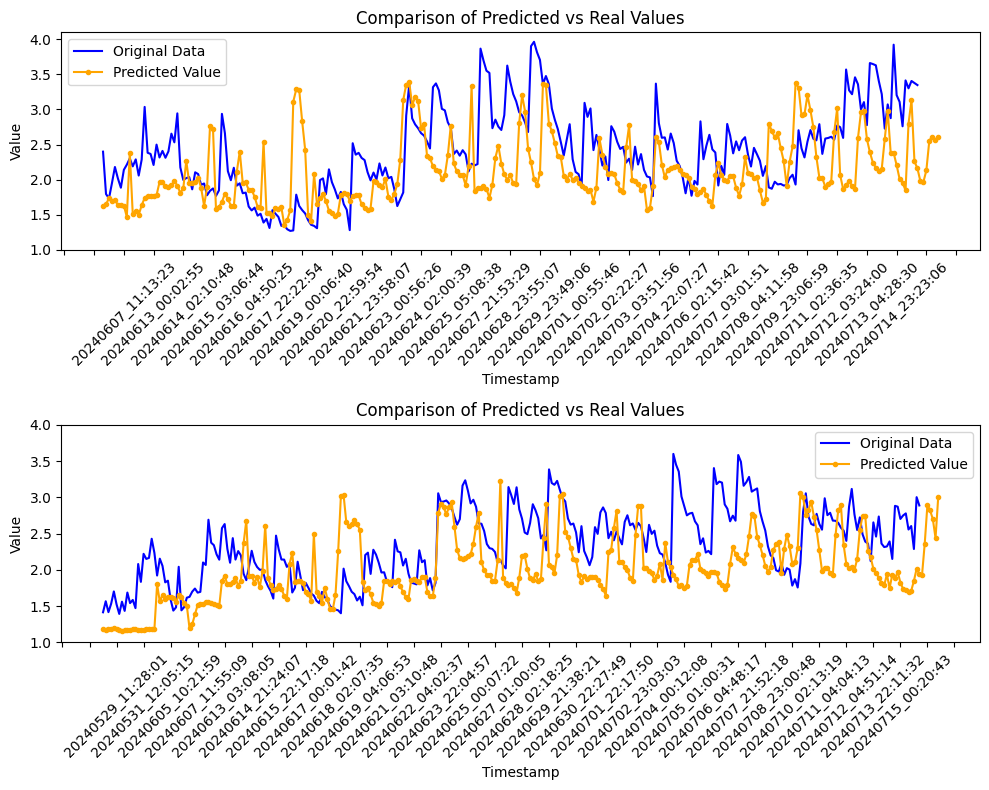

In [96]:
fig, axes = plt.subplots(2, 1, figsize=(10,8))
axes = axes.flatten()

for i, axe in enumerate(axes):
    id = [59,67]
    df = compare_n_hour(id[i], 8)
    dataX, do, future_predict, train_size,val_size, mean,std,res = Predict_n_ahead(id[i],8)
    do = do.iloc[11:, 0]
    axe.plot(do, color = 'blue', label = 'Original Data')
    axe.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    # Plot predicted values
    axe.plot(df['predicted_value'].shift(-1), color = 'orange', label='Predicted Value', marker='.')

    # Add labels, legend, and grid
    axe.set_xlabel('Timestamp')
    axe.set_ylabel('Value')
    axe.set_title('Comparison of Predicted vs Real Values')
    axe.legend()
    axe.xaxis.set_tick_params(rotation=45)
    axe.set_yticks(np.arange(np.floor(1), np.ceil(4) + 0.5, 0.5))
    print(df['predicted_value'].shift(-1))

# Show the plot
plt.tight_layout()
plt.show()


In [97]:
def mean_accuracy_ahead_dawn(hour_ahead):
    pond = [59,60,61,65,66,67]
    mean_acc = []
    mean_mae = []
    mean_rmse = []
    for id in pond:
        df = compare_n_hour(id, 8)
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d_%H:%M:%S')
        filtered_df = df[(df['timestamp'].dt.hour >= 4) & (df['timestamp'].dt.hour < 6)]
        filtered_df['accuracy'] = (1 - np.abs((filtered_df['real_value'] - filtered_df['predicted_value']) / df['real_value'])) * 100
        filtered_df['MAE'] = mean_absolute_error(filtered_df['real_value'],filtered_df['predicted_value'])
        filtered_df['RMSE'] = np.sqrt(mean_squared_error(filtered_df['real_value'],filtered_df['predicted_value']))
        acc = filtered_df['accuracy'].mean()
        rmse = filtered_df['RMSE'].mean()
        mae = filtered_df['MAE'].mean()
        mean_acc.append(acc)

        mean_mae.append(mae)
        mean_rmse.append(rmse)
    ACC = min(mean_acc)
    MAE = max(mean_mae)
    RMSE = max(mean_rmse)
    
    print("MAE:", MAE, "RMSE:", RMSE, "Accuracy:", ACC)
mean_accuracy_ahead_dawn(8)


MAE: 0.4007621379825474 RMSE: 0.526257236494646 Accuracy: 79.64245187422183


In [98]:
def mean_accuracy_ahead_asd(hour_ahead):
    pond = [59,60,61,65,66,67]
    mean_acc = []
    mean_mae = []
    mean_rmse = []
    for id in pond:
        df = compare_n_hour(id, hour_ahead)
        df['accuracy'] = (1 - np.abs((df['real_value'] - df['predicted_value']) / df['real_value'])) * 100
        df['MAE'] = mean_absolute_error(df['real_value'],df['predicted_value'])
        df['RMSE'] = np.sqrt(mean_squared_error(df['real_value'],df['predicted_value']))
        acc = df['accuracy'].mean()
        rmse  = df['RMSE'].mean()
        mae = df['MAE'].mean()
       
        mean_acc.append(acc)
        mean_mae.append(mae)
        mean_rmse.append(rmse)
    print(mean_acc)   
    ACC = min(mean_acc)
    MAE = min(mean_mae)
    RMSE = min(mean_rmse)
    
    print("MAE:", MAE, "RMSE:", RMSE, "Accuracy:", ACC)
#mean_accuracy_ahead_asd(8)

In [99]:
def mean_accuracy_ahead(hour_ahead):
    pond = [59,60,61,65,66,67]
    mean_acc = []
    mean_mae = []
    mean_rmse = []
    for id in pond:
        acc = compare_n_hour(id, hour_ahead)['accuracy'].mean()
        rmse  = compare_n_hour(id, hour_ahead)['RMSE'].mean()
        mae = compare_n_hour(id, hour_ahead)['MAE'].mean()
       
        mean_acc.append(acc)
        mean_mae.append(mae)
        mean_rmse.append(rmse)
        
    ACC = min(mean_acc)
    MAE = max(mean_mae)
    RMSE = max(mean_rmse)
    
    print("MAE:", MAE, "RMSE:", RMSE, "Accuracy:", ACC)
mean_accuracy_ahead(8)

MAE: 0.6432177596107655 RMSE: 0.7978547722776345 Accuracy: 0.737950691557546


In [100]:

def get_part_of_day(timestamp):
    latitude, longitude = 37.708961, -89.449699
    timezone = 'America/Chicago'
    location = LocationInfo(latitude=latitude, longitude=longitude, timezone=timezone)  
    date = timestamp.date()
    s = sun(location.observer, date=date)

    # Define dawn range: one hour before dawn to one hour after dawn
    dawn_start = s['dawn'] - timedelta(hours=1)
    dawn_end = s['dawn'] + timedelta(hours=1)
    
    if dawn_start <= timestamp < dawn_end:
        return 'dawn'
    elif s['dawn'] <= timestamp < s['sunrise']:
        return 'dawn'
    elif s['sunrise'] <= timestamp < s['noon']:
        return 'morning'
    elif s['noon'] <= timestamp < s['sunset']:
        return 'afternoon'
    elif s['sunset'] <= timestamp < s['dusk']:
        return 'dusk'
    else:
        return 'night'

def accuracy_with_time(pond_id, hour_ahead):
    df = compare_n_hour(pond_id, hour_ahead)

    location = LocationInfo(latitude=37.708961, longitude=-89.449699, timezone="America/Chicago")
    central_timezone = pytz.timezone("America/Chicago")
    # Convert the `timestamp` column to datetime if it isn't already
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d_%H:%M:%S')
    df['timestamp'] = df['timestamp'].apply(lambda ts: central_timezone.localize(ts))
    # Apply the function to create the new column
    df['time_of_day'] = df['timestamp'].apply(get_part_of_day)

    # Display the first few rows of the updated DataFrame
    dawn_rows = df[df['time_of_day'] == 'dawn']
    return dawn_rows['accuracy'].mean(), df
def mean_acc(n_ahead):
    ponds = [59,60,61,65,66,67]
    accuracy = 0
    for i in range(len(ponds)):
        acc, df = accuracy_with_time(ponds[i], n_ahead)
        accuracy += acc
    accuracy = accuracy/6
    return accuracy
mean_acc(8)

0.8090234664065944

In [166]:
def extract_daily_cycles_simple(data, start_hour=21, end_hour=5):
    """
    Simpler approach: group by night periods
    """
    data['datetime'] = pd.to_datetime(data.index, format='%Y%m%d_%H:%M:%S')
    data['hour'] = data['datetime'].dt.hour
    
    # Create night group identifier
    data['night_date'] = data['datetime'].dt.date
    # If hour <= 5, it belongs to previous night
    data.loc[data['hour'] <= end_hour, 'night_date'] = \
        data.loc[data['hour'] <= end_hour, 'datetime'].dt.date - pd.Timedelta(days=1)
    
    # Filter only night hours (21-23 and 0-5)
    night_data = data[(data['hour'] >= start_hour) | (data['hour'] <= end_hour)].copy()
    
    # Group by night_date
    cycles = []
    for night_date, group in night_data.groupby('night_date'):
        # Sort by datetime to ensure proper order
        group = group.sort_values('datetime')
        if len(group) >= 4:  # Ensure we have enough points
            cycles.append(group)
    for i in range(len(cycles)):
        cycles[i] = cycles[i].drop(['datetime', 'hour', 'night_date'], axis=1)
    
    return cycles
cycles = extract_daily_cycles_simple(getData_5feature_tensor(67), 20, 5)
cycles[1]

do  external_temp  prcp  wspd         ghi  \
formatted_index                                                      
20240613_21:36:14  2.436300           29.4   0.0  16.6  524.613650   
20240613_22:11:55  2.140686           29.4   0.0  16.6  524.613650   
20240614_00:05:47  2.257851           26.1   0.0  13.0  136.090601   
20240614_02:14:01  2.197772           22.8   0.0   0.0    0.000000   
20240614_03:08:29  1.946111           22.8   0.0   0.0    0.000000   
20240614_04:04:56  1.856677           20.6   0.0   5.4    0.000000   
20240614_05:01:23  2.043674           22.2   0.0  14.8    0.000000   

                   hour_minute  
formatted_index                 
20240613_21:36:14    21.600000  
20240613_22:11:55    22.183333  
20240614_00:05:47     0.083333  
20240614_02:14:01     2.233333  
20240614_03:08:29     3.133333  
20240614_04:04:56     4.066667  
20240614_05:01:23     5.016667

In [167]:
def prepare_model_input(input_data):
    """
    Convert cycle data to model input format
    """
    # 确保只使用6个特征
    features = ['do', 'external_temp', 'prcp', 'wspd', 'ghi', 'hour_minute']
    model_input = input_data[features].values
    
    # 转换为torch tensor并调整形状
    tensor_input = torch.tensor(model_input, dtype=torch.float32)
    
    # 调整形状为 (batch_size, sequence_length, features)
    # batch_size=1, sequence_length=4, features=6
    tensor_input = tensor_input.unsqueeze(0)  # 添加batch dimension
    
    print(f"Input shape: {tensor_input.shape}")  # 调试用
    return tensor_input

def update_input_for_next_step(current_input, pred):
    """
    Update input window for next prediction step
    """
    # 假设pred是形状为(1, 1, 2)的tensor，我们只需要DO值
    do_pred = pred[:, :, :1]  # 取DO预测值
    
    # 获取当前输入的最后一行，更新DO值
    last_input = current_input[:, -1:, :].clone()  # 复制最后一个时间步
    last_input[:, :, 0] = do_pred.squeeze(-1)  # 更新DO值
    
    # 滑动窗口：移除第一个时间步，添加新的预测
    updated_input = torch.cat([current_input[:, 1:, :], last_input], dim=1)
    
    return updated_input


In [168]:
def denormalize_predictions(predictions, mean, std, feature_index=0):
    pred_array = np.array(predictions)
    
    # 反标准化公式: original = normalized * std + mean
    denormalized = pred_array * std[feature_index] + mean[feature_index]
    
    return denormalized.tolist()


In [173]:
cycle_data0 = cycles[10]
print(cycle_data0)
test = getTest_set()
_, _, _, _, _, _, _, _, mean, std = train_test_split(test)
def recursive_predict_cycle(model, cycle_data, input_window):
    """
    Use first 4 points to recursively predict the remaining points
    """
    model.eval()  
    input_data = cycle_data.iloc[:input_window]  # First 4 points (9PM-12AM)
    remaining_points = len(cycle_data) - input_window  # Points to predict
    # Prepare input for model (adjust based on your model's input format)
    # This is a simplified version - adjust according to your actual model input format
    current_input = prepare_model_input(input_data)
    predictions = []
    predictions_denormalized = []

    with torch.no_grad(): 
        for step in range(remaining_points):
            # Predict next point
            pred = model(current_input)  # Adjust based on your model
            do_prediction = pred[:, :, 0].item()
            predictions.append(do_prediction)

            do_prediction_denorm = do_prediction * std[0] + mean[0]
            predictions_denormalized.append(do_prediction_denorm)


            current_input = update_input_for_next_step(current_input, pred)
        
        return predictions_denormalized
predictions = recursive_predict_cycle(lstm,cycle_data0, 4)
predictions


                         do  external_temp  prcp  wspd         ghi  \
formatted_index                                                      
20240623_21:19:49  3.054890           33.3   0.0  14.8  700.717575   
20240623_22:04:57  2.934289           32.8   0.0  11.2  532.060115   
20240623_23:02:49  2.941300           32.8   0.0  13.0  339.270347   
20240623_23:59:12  2.955878           30.0   0.0   0.0  144.233612   
20240624_01:07:48  2.916610           25.6   0.0   0.0    6.811581   
20240624_02:03:30  2.849176           25.6   0.0   0.0    0.000000   
20240624_03:02:21  2.730969           22.8   0.0   0.0    0.000000   
20240624_04:14:45  2.622093           21.7   0.0   0.0    0.000000   
20240624_04:55:08  2.698664           21.1   0.0   0.0    0.000000   

                   hour_minute  
formatted_index                 
20240623_21:19:49    21.316667  
20240623_22:04:57    22.066667  
20240623_23:02:49    23.033333  
20240623_23:59:12    23.983333  
20240624_01:07:48     1.116667 

[2.680682140226458,
 2.607824397041573,
 2.5514002273777274,
 2.5120365153576114,
 2.5057924147159576]

In [181]:
def prepare_model_input(input_data, mean, std):
    """
    Convert cycle data to model input format with normalization
    """
    features = ['do', 'external_temp', 'prcp', 'wspd', 'ghi', 'hour_minute']
    
    # 提取特征值
    model_input = input_data[features].values
    
    # 标准化输入: (value - mean) / std
    normalized_input = (model_input - mean) / std
    
    # 转换为torch tensor并调整形状
    tensor_input = torch.tensor(normalized_input, dtype=torch.float32)
    tensor_input = tensor_input.unsqueeze(0)  # 添加batch dimension (1, 4, 6)
    
    return tensor_input

def update_input_for_next_step(current_input, pred, last_input_row, mean, std):
    """
    Update input window for next prediction step
    """
    # pred是模型输出，已经是标准化的
    do_pred = pred[:, :, 0:1]  # 取DO预测值（标准化的）
    
    # 获取上一个时间步的其他特征（温度、天气等）
    # 这些特征需要从原始数据中获取并标准化
    next_features = last_input_row.copy()
    
    # 更新hour_minute（假设每小时+1）
    next_features[5] = (next_features[5] + 1) % 24  # hour_minute
    
    # 标准化其他特征
    normalized_features = (next_features - mean) / std
    
    # 用预测的DO替换
    normalized_features[0] = do_pred.squeeze().item()  # 替换DO值
    
    # 创建新的输入行
    new_input = torch.tensor(normalized_features, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # 滑动窗口：移除第一个时间步，添加新的预测
    updated_input = torch.cat([current_input[:, 1:, :], new_input], dim=1)
    
    return updated_input

def recursive_predict_cycle(model, cycle_data, mean, std, input_window=4):
    """
    Single model recursive prediction with normalization
    """
    model.eval()
    
    input_data = cycle_data.iloc[:input_window]  # First 4 points
    remaining_points = len(cycle_data) - input_window
    
    # 准备标准化的模型输入
    current_input = prepare_model_input(input_data, mean, std)
    
    predictions_normalized = []
    predictions_denormalized = []
    
    with torch.no_grad():
        for step in range(remaining_points):
            # 预测
            pred = model(current_input)
            
            # 提取DO预测值（标准化的）
            do_prediction_norm = pred[:, :, 0].item()
            predictions_normalized.append(do_prediction_norm)
            
            # 反标准化DO预测值
            do_prediction_denorm = do_prediction_norm * std[0] + mean[0]
            predictions_denormalized.append(do_prediction_denorm)
            
            # 为下一步准备输入（需要获取下一个时间步的其他特征）
            if step < remaining_points - 1:  # 如果不是最后一步
                next_step_index = input_window + step + 1
                if next_step_index < len(cycle_data):
                    next_row_features = cycle_data.iloc[next_step_index][['external_temp', 'prcp', 'wspd', 'ghi', 'hour_minute']].values
                    # 构造完整的特征行（DO用预测值，其他用真实值）
                    full_next_features = np.concatenate([[0], next_row_features])  # DO位置先用0占位
                else:
                    # 如果没有更多数据，使用最后一行的特征
                    full_next_features = cycle_data.iloc[-1][['do', 'external_temp', 'prcp', 'wspd', 'ghi', 'hour_minute']].values
                
                # 更新输入
                current_input = update_input_for_next_step(current_input, pred, full_next_features, mean, std)
    
    return predictions_denormalized

def linear_predict_cycle(cycle_data, input_window=4):
    """
    Create linear predictions using first and last input points
    """
    input_data = cycle_data.iloc[:input_window]  # First 4 points
    remaining_points = len(cycle_data) - input_window
    
    # Get first and last input points
    first_point = input_data['do'].iloc[0]
    last_point = input_data['do'].iloc[-1]
    
    # Calculate linear slope
    slope = (last_point - first_point) / (input_window - 1)
    
    # Generate linear predictions
    predictions = []
    for step in range(remaining_points):
        # Continue the linear trend
        pred_value = last_point + slope * (step + 1)
        predictions.append(pred_value)
    
    return predictions

def visualize_lstm_vs_linear_predictions(cycles, model, mean, std, model_name="LSTM"):
    """
    Side-by-side comparison: LSTM vs Linear Predictor
    """
    n_cycles = len(cycles)
    
    # Create subplots: 2 columns for each cycle
    fig, axes = plt.subplots(n_cycles, 2, figsize=(20, 4*n_cycles))
    if n_cycles == 1:
        axes = axes.reshape(1, -1)
    
    for cycle_idx, cycle in enumerate(cycles):
        if len(cycle) < 5:
            continue
            
        # LSTM predictions
        lstm_predictions = recursive_predict_cycle(model, cycle, mean, std)
        
        # Linear predictions
        linear_predictions = linear_predict_cycle(cycle)
        
        # Prepare plotting data
        time_points = range(len(cycle))
        input_points = time_points[:4]
        pred_points = time_points[4:]
        
        # Left subplot: LSTM predictions
        ax_lstm = axes[cycle_idx, 0]
        
        # Plot ground truth
        ax_lstm.plot(time_points, cycle['do'], 'bo-', linewidth=2, 
                    label='Ground Truth', markersize=6)
        
        # Highlight input points
        ax_lstm.plot(input_points, cycle['do'].iloc[:4], 'bo', 
                    markersize=10, markerfacecolor='lightblue', 
                    markeredgecolor='blue', markeredgewidth=2,
                    label='Input Points')
        
        # Plot LSTM predictions
        ax_lstm.plot(pred_points, lstm_predictions, 'r--s', linewidth=2,
                    label=f'{model_name} Predictions', markersize=6)
        
        # Styling for LSTM plot
        ax_lstm.set_xlabel('Time Step')
        ax_lstm.set_ylabel('DO (mg/L)')
        ax_lstm.set_title(f'Cycle {cycle_idx + 1}: {model_name} Prediction')
        ax_lstm.grid(True, alpha=0.3)
        ax_lstm.legend()
        
        # Highlight dawn period
        if len(pred_points) >= 2:
            dawn_start = len(time_points) - 2
            ax_lstm.axvspan(dawn_start - 0.5, len(time_points) - 0.5, 
                           alpha=0.2, color='yellow', label='Dawn Period')
        
        # Right subplot: Linear predictions
        ax_linear = axes[cycle_idx, 1]
        
        # Plot ground truth
        ax_linear.plot(time_points, cycle['do'], 'bo-', linewidth=2, 
                      label='Ground Truth', markersize=6)
        
        # Highlight input points
        ax_linear.plot(input_points, cycle['do'].iloc[:4], 'bo', 
                      markersize=10, markerfacecolor='lightblue', 
                      markeredgecolor='blue', markeredgewidth=2,
                      label='Input Points')
        
        # Plot linear predictions
        ax_linear.plot(pred_points, linear_predictions, 'g--^', linewidth=2,
                      label='Linear Predictions', markersize=6)
        
        # Draw the linear trend line through input points
        ax_linear.plot(input_points, cycle['do'].iloc[:4], 'g--', 
                      linewidth=1, alpha=0.7, label='Linear Trend')
        
        # Styling for Linear plot
        ax_linear.set_xlabel('Time Step')
        ax_linear.set_ylabel('DO (mg/L)')
        ax_linear.set_title(f'Cycle {cycle_idx + 1}: Linear Prediction')
        ax_linear.grid(True, alpha=0.3)
        ax_linear.legend()
        
        # Highlight dawn period
        if len(pred_points) >= 2:
            dawn_start = len(time_points) - 2
            ax_linear.axvspan(dawn_start - 0.5, len(time_points) - 0.5, 
                             alpha=0.2, color='yellow', label='Dawn Period')
        
        # Make y-axis consistent between subplots
        y_min = min(min(cycle['do']), min(lstm_predictions), min(linear_predictions)) * 0.95
        y_max = max(max(cycle['do']), max(lstm_predictions), max(linear_predictions)) * 1.05
        ax_lstm.set_ylim(y_min, y_max)
        ax_linear.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()
    return fig

def compare_prediction_accuracy(cycles, model, mean, std):
    """
    Compare accuracy between LSTM and Linear predictions
    """
    lstm_errors = []
    linear_errors = []
    dawn_lstm_errors = []
    dawn_linear_errors = []
    
    for cycle in cycles:
        if len(cycle) < 5:
            continue
            
        # Get predictions
        lstm_preds = recursive_predict_cycle(model, cycle, mean, std)
        linear_preds = linear_predict_cycle(cycle)
        
        # Get ground truth for prediction period
        gt = cycle['do'].iloc[4:].values
        
        # Calculate errors
        lstm_mae = np.mean(np.abs(np.array(lstm_preds) - gt))
        linear_mae = np.mean(np.abs(np.array(linear_preds) - gt))
        
        lstm_errors.append(lstm_mae)
        linear_errors.append(linear_mae)
        
        # Dawn period errors (last 2 points)
        if len(gt) >= 2:
            dawn_gt = gt[-2:]
            dawn_lstm = lstm_preds[-2:]
            dawn_linear = linear_preds[-2:]
            
            dawn_lstm_mae = np.mean(np.abs(np.array(dawn_lstm) - dawn_gt))
            dawn_linear_mae = np.mean(np.abs(np.array(dawn_linear) - dawn_gt))
            
            dawn_lstm_errors.append(dawn_lstm_mae)
            dawn_linear_errors.append(dawn_linear_mae)
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Overall MAE comparison
    ax1.boxplot([lstm_errors, linear_errors], labels=['LSTM', 'Linear'])
    ax1.set_title('Overall Prediction MAE Comparison')
    ax1.set_ylabel('MAE (mg/L)')
    ax1.grid(True, alpha=0.3)
    
    # Dawn period MAE comparison
    ax2.boxplot([dawn_lstm_errors, dawn_linear_errors], labels=['LSTM', 'Linear'])
    ax2.set_title('Dawn Period MAE Comparison')
    ax2.set_ylabel('MAE (mg/L)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== Prediction Accuracy Comparison ===")
    print(f"Overall MAE - LSTM: {np.mean(lstm_errors):.4f} ± {np.std(lstm_errors):.4f}")
    print(f"Overall MAE - Linear: {np.mean(linear_errors):.4f} ± {np.std(linear_errors):.4f}")
    print(f"Dawn MAE - LSTM: {np.mean(dawn_lstm_errors):.4f} ± {np.std(dawn_lstm_errors):.4f}")
    print(f"Dawn MAE - Linear: {np.mean(dawn_linear_errors):.4f} ± {np.std(dawn_linear_errors):.4f}")
    
    return {
        'lstm_mae': lstm_errors,
        'linear_mae': linear_errors,
        'dawn_lstm_mae': dawn_lstm_errors,
        'dawn_linear_mae': dawn_linear_errors
    }

# Usage example
def analyze_with_linear_baseline(data, model, model_name="LSTM"):
    """
    Complete analysis with linear baseline comparison
    """
    # Prepare data
    cycles = extract_daily_cycles_simple(data, 21, 5)
    mean, std = get_normalization_params(data)
    
    print(f"Analyzing {len(cycles)} cycles with {model_name} vs Linear baseline")
    
    # Create side-by-side visualization
    prediction_fig = visualize_lstm_vs_linear_predictions(
        cycles=cycles, 
        model=model, 
        mean=mean, 
        std=std, 
        model_name=model_name
    )
    
    # Compare accuracy
    accuracy_results = compare_prediction_accuracy(cycles, model, mean, std)
    
    return cycles, prediction_fig, accuracy_results
def get_normalization_params(data):
    """
    从单个数据集计算normalization参数
    """
    features = ['do', 'external_temp', 'prcp', 'wspd', 'ghi', 'hour_minute']
    feature_data = data[features].values
    
    mean = np.mean(feature_data, axis=0)
    std = np.std(feature_data, axis=0)
    
    return mean, std

Analyzing 34 cycles with LSTM vs Linear baseline


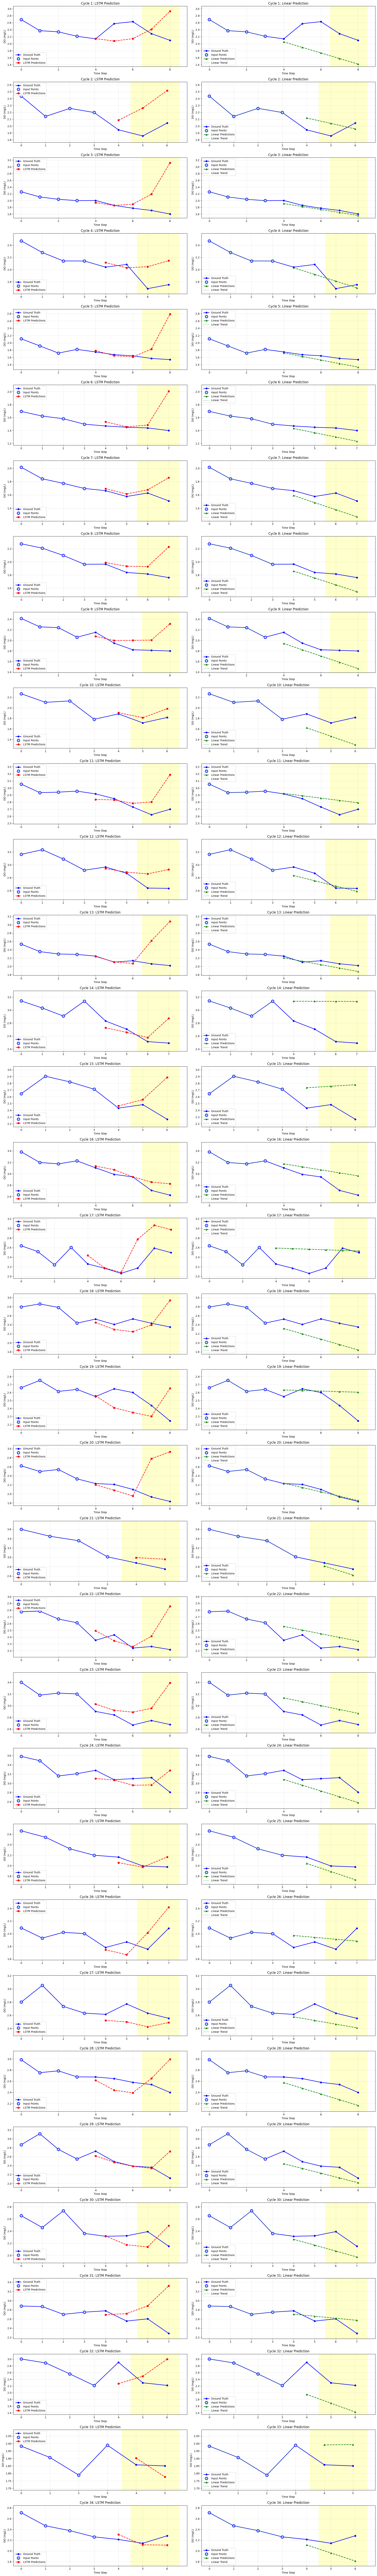

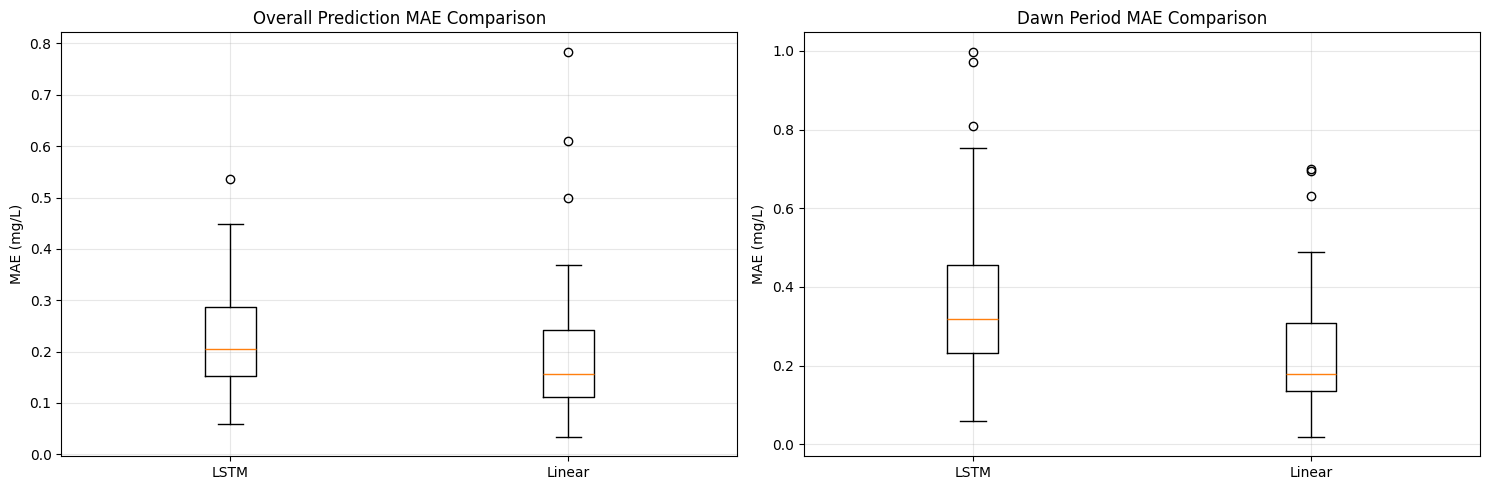

=== Prediction Accuracy Comparison ===
Overall MAE - LSTM: 0.2271 ± 0.1127
Overall MAE - Linear: 0.2099 ± 0.1576
Dawn MAE - LSTM: 0.3723 ± 0.2279
Dawn MAE - Linear: 0.2382 ± 0.1723


In [182]:
data = getData_5feature_tensor(67)
test = getTest_set()
cycles = extract_daily_cycles_simple(data, 21, 5)

# 2. 获取normalization参数
_, _, _, _, _, _, _, _, mean, std = train_test_split(test)

# 3. 可视化单个模型的预测
cycles, fig, results = analyze_with_linear_baseline(
    data=data, 
    model=lstm, 
    model_name="LSTM"
)

In [170]:
def data_7_5am():
    df = pd.read_csv("data-7.csv")
    df = df.iloc[:, [0,1]]
    df = df.iloc[290:]
    df['Time (est)'] = pd.to_datetime(df['Time (est)'])

    # 2. Filter rows where the hour is 5 (5:00 AM)
    df_5am = df[df['Time (est)'].dt.hour == 5]

    # 3. Plot time vs dissolved oxygen
    plt.plot(df_5am['Time (est)'], df_5am['IRL-JB-WQ Dissolved oxygen (mg/L)'], marker='o')
    plt.title('Dissolved Oxygen at 5 AM')
    plt.xlabel('Date')
    plt.ylabel('Dissolved Oxygen (mg/L)')
    plt.xticks(rotation=45)  # optional: rotate x-axis labels
    plt.tight_layout()
    plt.show()

In [108]:
df = compare_n_hour(67,8)

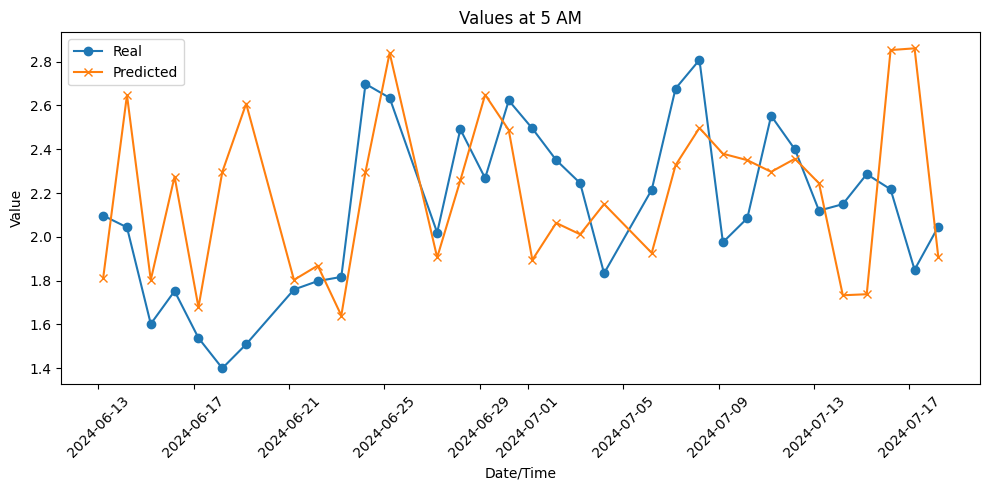

In [109]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d_%H:%M:%S')

# 2. Filter rows where the hour is 4 or 5 (i.e., 4:00-5:59)
df = df[df['timestamp'].dt.hour.isin([4, 5])]
df = df.sort_values(by='timestamp')

# 2. Group by date portion of the timestamp, then pick the last row in each group
df_5am= (
    df
    .groupby(df['timestamp'].dt.date, as_index=False)
    .tail(1)
)
# 3. Plot the real vs. predicted values at 5 AM
plt.figure(figsize=(10,5))
plt.plot(df_5am['timestamp'], df_5am['real_value'], marker='o', label='Real')
plt.plot(df_5am['timestamp'], df_5am['predicted_value'], marker='x', label='Predicted')
plt.xlabel('Date/Time')
plt.ylabel('Value')
plt.title('Values at 5 AM')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()



In [110]:
'''import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- FIRST DATA: Dissolved oxygen at 5 AM (from, say, 2023) ---
df = pd.read_csv("data-7.csv")
df = df.iloc[:, [0,1]]
df = df.iloc[290:]
df['Time (est)'] = pd.to_datetime(df['Time (est)'])
df_5am_do = df[df['Time (est)'].dt.hour == 5]

# Create a "plot_time" column that sets every timestamp's year to 2000 (arbitrary choice)
df_5am_do['plot_time'] = df_5am_do['Time (est)'].apply(lambda t: t.replace(year=2000))

# --- SECOND DATA: Real vs. Predicted at ~4–5 AM (from, say, 2024) ---
df2 = compare_n_hour(67,8)
df2['timestamp'] = pd.to_datetime(df2['timestamp'], format='%Y%m%d_%H:%M:%S')
df2 = df2[df2['timestamp'].dt.hour.isin([4, 5])]
df2 = df2.sort_values(by='timestamp')
df2_5am = df2.groupby(df2['timestamp'].dt.date, as_index=False).tail(1)

# Similarly, unify the year (e.g., set to 2000)
df2_5am['plot_time'] = df2_5am['timestamp'].apply(lambda t: t.replace(year=2000))

# --- PLOT ALL CURVES ON ONE AXIS ---
plt.figure(figsize=(10,6))

# Dissolved Oxygen
plt.plot(
    df_5am_do['plot_time'], 
    df_5am_do['IRL-JB-WQ Dissolved oxygen (mg/L)'], 
    marker='o', 
    color='blue', 
    label='Dissolved Oxygen (5 AM)'
)

# Real Value
plt.plot(
    df2_5am['plot_time'], 
    df2_5am['real_value'], 
    marker='x', 
    color='red', 
    label='Real Value (4–5 AM)'
)

# Predicted Value
plt.plot(
    df2_5am['plot_time'], 
    df2_5am['predicted_value'], 
    marker='^', 
    color='green', 
    label='Predicted Value (4–5 AM)'
)

# Format the x-axis to ignore the year and only show month-day, time, etc.
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

plt.title('Combined Curves')
plt.xlabel('Month-Day Hour:Min')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
'''

'import pandas as pd\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\n\n# --- FIRST DATA: Dissolved oxygen at 5 AM (from, say, 2023) ---\ndf = pd.read_csv("data-7.csv")\ndf = df.iloc[:, [0,1]]\ndf = df.iloc[290:]\ndf[\'Time (est)\'] = pd.to_datetime(df[\'Time (est)\'])\ndf_5am_do = df[df[\'Time (est)\'].dt.hour == 5]\n\n# Create a "plot_time" column that sets every timestamp\'s year to 2000 (arbitrary choice)\ndf_5am_do[\'plot_time\'] = df_5am_do[\'Time (est)\'].apply(lambda t: t.replace(year=2000))\n\n# --- SECOND DATA: Real vs. Predicted at ~4–5 AM (from, say, 2024) ---\ndf2 = compare_n_hour(67,8)\ndf2[\'timestamp\'] = pd.to_datetime(df2[\'timestamp\'], format=\'%Y%m%d_%H:%M:%S\')\ndf2 = df2[df2[\'timestamp\'].dt.hour.isin([4, 5])]\ndf2 = df2.sort_values(by=\'timestamp\')\ndf2_5am = df2.groupby(df2[\'timestamp\'].dt.date, as_index=False).tail(1)\n\n# Similarly, unify the year (e.g., set to 2000)\ndf2_5am[\'plot_time\'] = df2_5am[\'timestamp\'].apply(lambda t: t.re

In [ ]:
def getData_5feature_tensor(pond_number):

    base_path = '/LH_Farm/pond_'
    pond = f"{base_path}{pond_number}"  #Get data from the firebase
    ref = db.reference(pond)
    data = ref.get()
    df = pd.DataFrame(data)
    df = df.T
    df = df[df['type'] != 'truck']
    df = df[['do', 'temp', 'pressure']]
    df = df[df.index.str[:8] < '20240801']
    do_res = remove_outliers_from_df(df)
    do_mean = Convert_mean(do_res) # Get mean of DO
    #do_mean['do'] = do_mean['do'].apply(lambda x: [convert_to_mgl(do, temp, pressure) for do, temp, pressure  in x])
    do_mean['do'] = do_mean.apply(lambda row: convert_to_mgl(row['do'], row['temp'], row['pressure']), axis=1)
    do_mean['datetime'] = pd.to_datetime(do_mean.index, format='%Y%m%d_%H:%M:%S')
    do_mean['datetime'] = do_mean['datetime'].dt.tz_localize('UTC')
    do_mean['datetime'] = do_mean['datetime'].dt.tz_convert('America/Chicago')
    do_mean['hour'] = do_mean['datetime'].dt.hour
    do_mean['minute'] = do_mean['datetime'].dt.minute
    do_mean['hour_minute'] = do_mean['hour'] + do_mean['minute'] / 60.0
    do_mean['formatted_index'] = do_mean['datetime'].dt.strftime('%Y%m%d_%H:%M:%S')
    do_mean = do_mean.set_index('formatted_index', drop=True)
    do_mean = do_mean.drop('datetime', axis = 1)
    do_mean = do_mean.drop('hour', axis = 1)
    do_mean = do_mean.drop('minute', axis = 1)
    #do_mean = do_mean.iloc[2:]
    # Extract hour and minute and create new columns
    #do_mean=fix_time(do_mean)
    do_mean = do_mean.iloc[:-10]
    do_mean['datetime'] = pd.to_datetime(do_mean.index, format='%Y%m%d_%H:%M:%S')
    do_mean_index = do_mean.index
    external_data['datetime'] = pd.to_datetime(external_data.index, format='%Y-%m-%d %H:%M:%S')
    do_mean['key'] = 1
    external_data['key'] = 1
    data_joined = pd.merge(do_mean, external_data, on='key').drop("key", axis=1)
    data_joined['time_diff'] = np.abs(data_joined['datetime_x'] - data_joined['datetime_y'])
    cloest_match = data_joined.loc[data_joined.groupby('datetime_x')['time_diff'].idxmin()]
    cloest_match = cloest_match.drop('time_diff', axis= 1).reset_index(drop = True)
    cloest_match = cloest_match.drop(['datetime_y','dwpt','rhum','wdir','wpgt','snow','pres','tsun','coco','datetime_x'], axis = 1)
    #cloest_match = cloest_match.rename(columns={'datetime_x': 'datetime'})
    cloest_match = cloest_match.rename(columns={'temp_x': 'temp'})
    cloest_match = cloest_match.rename(columns={'temp_y': 'external_temp'})
    cloest_match = cloest_match.set_index(do_mean_index)
    cloest_match = cloest_match.drop(['external_temp','dni','dhi','pressure'], axis = 1)
    new_order = [ 'do', 'temp', 'prcp', 'wspd', 'ghi','hour_minute']
    # DO, Air temperature, rain, wind, solar, hour
    #new_order = [ 'do', 'external_temp', 'prcp', 'wspd', 'ghi','hour_minute']
    cloest_match = cloest_match[new_order]
    cloest_match  = cloest_match.iloc[:-10]
    with open('latest_data.json', 'w') as f:
        json.dump(data, f)
    return cloest_match

In [ ]:
getData_5feature_tensor(65)

do       temp  prcp  wspd         ghi  hour_minute
formatted_index                                                            
20240528_11:44:45  1.363958  26.047222   0.0   0.0  116.068740    11.733333
20240528_12:00:21  1.284924  25.736154   0.0   0.0  116.068740    12.000000
20240528_12:14:54  1.250957  25.314211   0.0   0.0  116.068740    12.233333
20240528_14:41:07  1.419530  29.036571   0.0   0.0  116.068740    14.683333
20240528_14:42:14  1.419180  28.713333   0.0   0.0  116.068740    14.700000
...                     ...        ...   ...   ...         ...          ...
20240715_03:05:24  3.220153  28.802778   0.0  13.0    0.000000     3.083333
20240715_03:57:44  3.207022  28.682105   0.0  11.2    0.000000     3.950000
20240715_05:05:14  2.828593  29.427500   0.0  13.0    0.000000     5.083333
20240715_22:04:00  3.436789  32.017778   0.0  18.4  529.085455    22.066667
20240715_23:05:29  3.276135  31.029730   0.0  20.5  334.554561    23.083333

[314 rows x 6 columns]